In [ ]:
# prompt: /content/drive/MyDrive/sppe.zip 이거 압축해제

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
!pip install decord -qq




# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/sppe.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/')

In [ ]:
# from decord import VideoReader, cpu

# # 비디오 파일 로드
# video_path = '/content/200-1_cam01_kidnap01_place01_night_summer.mp4'
# vr = VideoReader(video_path, ctx=cpu(0))  # CPU 사용

# # 비디오 메타데이터 확인
# print(f"Total frames: {len(vr)}")
# # print(f"Video width: {vr.width}, height: {vr.height}, fps: {vr.get_avg_fps()}")

# # 첫 번째 프레임 읽기
# frame = vr[0]
# print(f"Frame shape: {frame.shape}")


In [2]:
# from queue import Queue
!pip install opencv-python -qq # Install the opencv-python package
import cv2




# # def update(self):
# #     while not stopped:
# #         if not Q.full():
# #             frames = []
# #             for k in range(batch_size):
# #                 ret, frame = stream.read()
# #                 if not ret:
# #                     stop()
# #                     return

# #                 if preprocess_fn is not None:
# #                     frame = preprocess_fn(frame)

# #                 frames.append(frame)
# #                 frames = np.stack(frames)
# #                 Q.put(frames)

# Q.get().squeeze()

In [ ]:
!pip install easydict==1.13
!pip install scipy==1.13.1

In [ ]:

# import matplotlib.pyplot as plt


# for i in range(5):
#   t = 100*i
#   frame = vr[t]
#   plt.imshow(frame.asnumpy())
#   plt.title("First Frame")
#   plt.show()

In [ ]:
def ResizePadding(height, width):
    desized_size = (height, width)

    def resizePadding(image, **kwargs):
        old_size = image.shape[:2]
        max_size_idx = old_size.index(max(old_size))
        ratio = float(desized_size[max_size_idx]) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])

        if new_size > desized_size:
            min_size_idx = old_size.index(min(old_size))
            ratio = float(desized_size[min_size_idx]) / min(old_size)
            new_size = tuple([int(x * ratio) for x in old_size])

        image = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = desized_size[1] - new_size[1]
        delta_h = desized_size[0] - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)
        return image
    return resizePadding

In [ ]:
import os
import cv2
import time
import torch
import numpy as np

from queue import Queue
from threading import Thread, Lock


class CamLoader:


    """Args:
        camera: (int, str) Source of camera or video.,
        preprocess: (Callable function) to process the frame before return.
    """
    def __init__(self, camera, preprocess=None, ori_return=False):
        self.stream = cv2.VideoCapture(camera)
        assert self.stream.isOpened(), 'Cannot read camera source!'
        self.fps = self.stream.get(cv2.CAP_PROP_FPS)
        self.frame_size = (int(self.stream.get(cv2.CAP_PROP_FRAME_WIDTH)),
                           int(self.stream.get(cv2.CAP_PROP_FRAME_HEIGHT)))

        self.stopped = False
        self.ret = False
        self.frame = None
        self.ori_frame = None
        self.read_lock = Lock()
        self.ori = ori_return

        self.preprocess_fn = preprocess

    def start(self):
        self.t = Thread(target=self.update, args=())  # , daemon=True)
        self.t.start()
        c = 0
        while not self.ret:
            time.sleep(0.1)
            c += 1
            if c > 20:
                self.stop()
                raise TimeoutError('Can not get a frame from camera!!!')
        return self

    def update(self):
        while not self.stopped:
            ret, frame = self.stream.read()
            self.read_lock.acquire()
            self.ori_frame = frame.copy()
            if ret and self.preprocess_fn is not None:
                frame = self.preprocess_fn(frame)

            self.ret, self.frame = ret, frame
            self.read_lock.release()

    def grabbed(self):
        """Return `True` if can read a frame."""
        return self.ret

    def getitem(self):
        self.read_lock.acquire()
        frame = self.frame.copy()
        ori_frame = self.ori_frame.copy()
        self.read_lock.release()
        if self.ori:
            return frame, ori_frame
        else:
            return frame

    def stop(self):
        if self.stopped:
            return
        self.stopped = True
        if self.t.is_alive():
            self.t.join()
        self.stream.release()

    def __del__(self):
        if self.stream.isOpened():
            self.stream.release()

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.stream.isOpened():
            self.stream.release()


class CamLoader_Q:
    """
    Args:
        camera: (int, str) Source of camera or video.,
        batch_size: (int) Number of batch frame to store in queue. Default: 1,
        queue_size: (int) Maximum queue size. Default: 256,
        preprocess: (Callable function) to process the frame before return.
    """
    def __init__(self, camera, batch_size=1, queue_size=256, preprocess=None):
        self.stream = cv2.VideoCapture(camera)
        assert self.stream.isOpened(), 'Cannot read camera source!'
        self.fps = self.stream.get(cv2.CAP_PROP_FPS)
        self.frame_size = (int(self.stream.get(cv2.CAP_PROP_FRAME_WIDTH)),
                           int(self.stream.get(cv2.CAP_PROP_FRAME_HEIGHT)))

        # Queue for storing each frames.

        self.stopped = False
        self.batch_size = batch_size
        self.Q = Queue(maxsize=queue_size)

        self.preprocess_fn = preprocess

    def start(self):
        t = Thread(target=self.update, args=(), daemon=True).start()
        c = 0
        while not self.grabbed():
            time.sleep(0.1)
            c += 1
            if c > 20:
                self.stop()
                raise TimeoutError('Can not get a frame from camera!!!')
        return self

    def update(self):
        while not self.stopped:
            if not self.Q.full():
                frames = []
                for k in range(self.batch_size):
                    ret, frame = self.stream.read()
                    if not ret:
                        self.stop()
                        return

                    if self.preprocess_fn is not None:
                        frame = self.preprocess_fn(frame)

                    frames.append(frame)
                    frames = np.stack(frames)
                    self.Q.put(frames)
            else:
                with self.Q.mutex:
                    self.Q.queue.clear()
            # time.sleep(0.05)

    def grabbed(self):
        """Return `True` if can read a frame."""
        return self.Q.qsize() > 0

    def getitem(self):
        return self.Q.get().squeeze()

    def stop(self):
        if self.stopped:
            return
        self.stopped = True
        self.stream.release()

    def __len__(self):
        return self.Q.qsize()

    def __del__(self):
        if self.stream.isOpened():
            self.stream.release()

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.stream.isOpened():
            self.stream.release()

# name == main 파일 존재

In [ ]:
import time
import torchvision.transforms as transforms

from queue import Queue
from threading import Thread

# from Detection.Models import Darknet 밑의 yoloclass 를 위한 darknet과 그 유틸리티 함수
def to_cpu(tensor):
    return tensor.detach().cpu()


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):
    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf


def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines]  # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['):  # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs
    #--------------------------------------------------------

class YOLOLayer(nn.Module):
    """Detection layer"""
    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):
        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask.bool()], tx[obj_mask.bool()])
            loss_y = self.mse_loss(y[obj_mask.bool()], ty[obj_mask.bool()])
            loss_w = self.mse_loss(w[obj_mask.bool()], tw[obj_mask.bool()])
            loss_h = self.mse_loss(h[obj_mask.bool()], th[obj_mask.bool()])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask.bool()], tconf[obj_mask.bool()])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask.bool()], tconf[noobj_mask.bool()])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask.bool()], tcls[obj_mask.bool()])
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask.bool()].mean()
            conf_obj = pred_conf[obj_mask.bool()].mean()
            conf_noobj = pred_conf[noobj_mask.bool()].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "w": to_cpu(loss_w).item(),
                "h": to_cpu(loss_h).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss

class Upsample(nn.Module):
    """ nn.Upsample is deprecated """
    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""
    def __init__(self):
        super(EmptyLayer, self).__init__()


def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]  # [3]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list

class Darknet(nn.Module):
    """YOLOv3 object detection model"""
    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        return yolo_outputs if targets is None else (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""
        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr: ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr: ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr: ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr: ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr: ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr: ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()

    def load_pretrain_to_custom_class(self, weights_pth_path):
        state = torch.load(weights_pth_path, weights_only=True)

        own_state = self.state_dict()
        for name, param in state.items():
            if name not in own_state:
                print(f'Model does not have this param: {name}!')
                continue

            if param.shape != own_state[name].shape:
                print(f'Do not load this param: {name} cause it shape not equal! : '
                      f'{param.shape} into {own_state[name].shape}')
                continue

            own_state[name].copy_(param)

# from Detection.Utils import non_max_suppression, ResizePadding
def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """
    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output

class TinyYOLOv3_onecls(object):
    """
    Args:
        input_size: (int) Size of input image must be divisible by 32. Default: 416,
        config_file: (str) Path to Yolo model structure config file.,
        weight_file: (str) Path to trained weights file.,
        nms: (float) Non-Maximum Suppression overlap threshold.,
        conf_thres: (float) Minimum Confidence threshold of predicted bboxs to cut off.,
        device: (str) Device to load the model on 'cpu' or 'cuda'.
    """
    def __init__(self,
                 input_size=416,
                #  config_file='Models/yMAolo-tiny-onecls/yolov3-tiny-onecls.cfg',
                 config_file = '/content/yolov3-tiny-onecls.cfg',
                 weight_file='/content/best-model.pth',
                 nms=0.2,
                 conf_thres=0.45,
                 device='cuda'):
        self.input_size = input_size
        self.model = Darknet(config_file).to(device)
        # self.model.load_state_dict(torch.load(weight_file))
        self.model.eval()
        self.device = device

        self.nms = nms
        self.conf_thres = conf_thres

        self.resize_fn = ResizePadding(input_size, input_size)
        self.transf_fn = transforms.ToTensor()

    def detect(self, image, need_resize=True, expand_bb=5):
        """
        Args:
            image: (numpy array) Single RGB image to detect.,
            need_resize: (bool) Resize to input_size before feed and will return bboxs
                with scale to image original size.,
            expand_bb: (int) Expand boundary of the boxs.
        Returns:
            (torch.float32) Of each detected object contain a
                [top, left, bottom, right, bbox_score, class_score, class]
            return `None` if no detected.
        """
        image_size = (self.input_size, self.input_size)
        if need_resize:
            image_size = image.shape[:2]
            image = self.resize_fn(image)

        image = self.transf_fn(image)[None, ...]
        scf = torch.min(self.input_size / torch.tensor([image_size],dtype=torch.float32), 1)[0]

        detected = self.model(image.to(self.device))
        detected = non_max_suppression(detected, self.conf_thres, self.nms)[0]
        if detected is not None:
            detected[:, [0, 2]] -= (self.input_size - scf * image_size[1]) / 2
            detected[:, [1, 3]] -= (self.input_size - scf * image_size[0]) / 2
            detected[:, 0:4] /= scf

            detected[:, 0:2] = np.maximum(0, detected[:, 0:2] - expand_bb)
            detected[:, 2:4] = np.minimum(image_size[::-1], detected[:, 2:4] + expand_bb)

        return detected

In [ ]:
COCO_PAIR = [(0, 13), (1, 2), (1, 3), (3, 5), (2, 4), (4, 6), (13, 7), (13, 8),  # Body
             (7, 9), (8, 10), (9, 11), (10, 12)]
POINT_COLORS = [(0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0),  # Nose, LEye, REye, LEar, REar
                (77, 255, 255), (77, 255, 204), (77, 204, 255), (191, 255, 77), (77, 191, 255), (191, 255, 77),  # LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
                (204, 77, 255), (77, 255, 204), (191, 77, 255), (77, 255, 191), (127, 77, 255), (77, 255, 127), (0, 255, 255)]  # LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
LINE_COLORS = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50), (77, 255, 222),
               (77, 196, 255), (77, 135, 255), (191, 255, 77), (77, 255, 77), (77, 222, 255),
               (255, 156, 127), (0, 127, 255), (255, 127, 77), (0, 77, 255), (255, 77, 36)]

MPII_PAIR = [(8, 9), (11, 12), (11, 10), (2, 1), (1, 0), (13, 14), (14, 15), (3, 4), (4, 5),
             (8, 7), (7, 6), (6, 2), (6, 3), (8, 12), (8, 13)]
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
CYAN = (255, 255, 0)
YELLOW = (0, 255, 255)
ORANGE = (0, 165, 255)
PURPLE = (255, 0, 255)
def draw_single(frame, pts, joint_format='coco'):
    if joint_format == 'coco':
        l_pair = COCO_PAIR
        p_color = POINT_COLORS
        line_color = LINE_COLORS
    elif joint_format == 'mpii':
        l_pair = MPII_PAIR
        p_color = [PURPLE, BLUE, BLUE, RED, RED, BLUE, BLUE, RED, RED, PURPLE, PURPLE, PURPLE, RED, RED,BLUE,BLUE]
    else:
        NotImplementedError

    part_line = {}
    pts = np.concatenate((pts, np.expand_dims((pts[1, :] + pts[2, :]) / 2, 0)), axis=0)
    for n in range(pts.shape[0]):
        if pts[n, 2] <= 0.05:
            continue
        cor_x, cor_y = int(pts[n, 0]), int(pts[n, 1])
        part_line[n] = (cor_x, cor_y)
        cv2.circle(frame, (cor_x, cor_y), 3, p_color[n], -1)

    for i, (start_p, end_p) in enumerate(l_pair):
        if start_p in part_line and end_p in part_line:
            start_xy = part_line[start_p]
            end_xy = part_line[end_p]
            cv2.line(frame, start_xy, end_xy, line_color[i], int(1*(pts[start_p, 2] + pts[end_p, 2]) + 1))
    return frame


In [ ]:


class SELayer(nn.Module):
    def __init__(self, channel, reduction=1):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, reduction=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        if reduction:
            self.se = SELayer(planes * 4)

        self.reduc = reduction
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.reduc:
            out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = F.relu(out)

        return out

class SEResnet(nn.Module):
    """ SEResnet """

    def __init__(self, architecture):
        super(SEResnet, self).__init__()
        assert architecture in ["resnet50", "resnet101"]
        self.inplanes = 64
        self.layers = [3, 4, {"resnet50": 6, "resnet101": 23}[architecture], 3]
        self.block = Bottleneck

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-5, momentum=0.01, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(self.block, 64, self.layers[0])
        self.layer2 = self.make_layer(
            self.block, 128, self.layers[1], stride=2)
        self.layer3 = self.make_layer(
            self.block, 256, self.layers[2], stride=2)

        self.layer4 = self.make_layer(
            self.block, 512, self.layers[3], stride=2)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))  # 64 * h/4 * w/4
        x = self.layer1(x)  # 256 * h/4 * w/4
        x = self.layer2(x)  # 512 * h/8 * w/8
        x = self.layer3(x)  # 1024 * h/16 * w/16
        x = self.layer4(x)  # 2048 * h/32 * w/32
        return x

    def stages(self):
        return [self.layer1, self.layer2, self.layer3, self.layer4]

    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        if downsample is not None:
            layers.append(block(self.inplanes, planes, stride, downsample, reduction=True))
        else:
            layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


class DUC(nn.Module):
    """
    INPUT: inplanes, planes, upscale_factor
    OUTPUT: (planes // 4)* ht * wd
    """
    def __init__(self, inplanes, planes, upscale_factor=2):
        super(DUC, self).__init__()
        self.conv = nn.Conv2d(inplanes, planes, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pixel_shuffle(x)
        return x


class opt:
    nClasses = 33
    inputResH = 384
    inputResW = 320
    outputResH = 96
    outputResW = 80
    scale = 0.25
    rotate = 30
    hmGauss = 1

class FastPose(nn.Module):
    DIM = 128

    def __init__(self, backbone='resnet101', num_join=opt.nClasses):
        super(FastPose, self).__init__()
        assert backbone in ['resnet50', 'resnet101']

        self.preact = SEResnet(backbone)

        self.suffle1 = nn.PixelShuffle(2)
        self.duc1 = DUC(512, 1024, upscale_factor=2)
        self.duc2 = DUC(256, 512, upscale_factor=2)

        self.conv_out = nn.Conv2d(
            self.DIM, num_join, kernel_size=3, stride=1, padding=1)

    def forward(self, x: Variable):
        out = self.preact(x)
        out = self.suffle1(out)
        out = self.duc1(out)
        out = self.duc2(out)

        out = self.conv_out(out)
        return out
def flip(x):
    assert (x.dim() == 3 or x.dim() == 4)
    dim = x.dim() - 1
    if '0.4.1' in torch.__version__ or '1.0' in torch.__version__:
        return x.flip(dims=(dim,))
    else:
        is_cuda = False
        if x.is_cuda:
            is_cuda = True
            x = x.cpu()
        x = x.numpy().copy()
        if x.ndim == 3:
            x = np.transpose(np.fliplr(np.transpose(x, (0, 2, 1))), (0, 2, 1))
        elif x.ndim == 4:
            for i in range(x.shape[0]):
                x[i] = np.transpose(
                    np.fliplr(np.transpose(x[i], (0, 2, 1))), (0, 2, 1))
        # x = x.swapaxes(dim, 0)
        # x = x[::-1, ...]
        # x = x.swapaxes(0, dim)

        x = torch.from_numpy(x.copy())
        if is_cuda:
            x = x.cuda()
        return x


def shuffleLR(x, dataset):
    flipRef = dataset.flipRef
    assert (x.dim() == 3 or x.dim() == 4)
    for pair in flipRef:
        dim0, dim1 = pair
        dim0 -= 1
        dim1 -= 1
        if x.dim() == 4:
            tmp = x[:, dim1].clone()
            x[:, dim1] = x[:, dim0].clone()
            x[:, dim0] = tmp.clone()
            #x[:, dim0], x[:, dim1] = deepcopy((x[:, dim1], x[:, dim0]))
        else:
            tmp = x[dim1].clone()
            x[dim1] = x[dim0].clone()
            x[dim0] = tmp.clone()
            #x[dim0], x[dim1] = deepcopy((x[dim1], x[dim0]))
    return x

import sys
class InferenNet(nn.Module):
    def __init__(self, dataset, weights_file='/content/sppe/fast_res101_320x256.pth'):
        super().__init__()

        self.pyranet = FastPose('resnet101').cuda()
        print('Loading pose model from {}'.format(weights_file))
        sys.stdout.flush()
        # self.pyranet.load_state_dict(torch.load(weights_file))
        self.pyranet.eval()
        # self.pyranet = model

        self.dataset = dataset

    def forward(self, x):
        out = self.pyranet(x)
        out = out.narrow(1, 0, 17)

        flip_out = self.pyranet(flip(x))
        flip_out = flip_out.narrow(1, 0, 17)

        flip_out = flip(shuffleLR(
            flip_out, self.dataset))

        out = (flip_out + out) / 2

        return out


class InferenNet_fast(nn.Module):
    def __init__(self, weights_file='/content/fast_res101_320x256.pth'):
        super().__init__()

        self.pyranet = FastPose('resnet101').cuda()
        print('Loading pose model from {}'.format(weights_file))
        self.pyranet.load_state_dict(torch.load(weights_file, weights_only=True))
        self.pyranet.eval()

    def forward(self, x):
        out = self.pyranet(x)
        out = out.narrow(1, 0, 17)

        return out


class InferenNet_fastRes50(nn.Module):
    def __init__(self, weights_file='/content/fast_res50_256x192.pth'):
        super().__init__()

        self.pyranet = FastPose('resnet50', 17).cuda()
        print('Loading pose model from {}'.format(weights_file))
        # self.pyranet.load_state_dict(torch.load(weights_file))
        self.pyranet.eval()

    def forward(self, x):
        out = self.pyranet(x)

        return out



In [ ]:
import os
import cv2
import torch

def to_torch(ndarray):
    if type(ndarray).__module__ == 'numpy':
        return torch.from_numpy(ndarray)
    elif not torch.is_tensor(ndarray):
        raise ValueError("Cannot convert {} to torch tensor"
                         .format(type(ndarray)))
    return ndarray


def im_to_torch(img):
    img = np.array(img)
    img = np.transpose(img, (2, 0, 1))  # C*H*W
    img = to_torch(img).float()
    if img.max() > 1:
        img /= 255
    return img

def to_numpy(tensor):
    if torch.is_tensor(tensor):
        return tensor.cpu().numpy()
    elif type(tensor).__module__ != 'numpy':
        raise ValueError("Cannot convert {} to numpy array"
                         .format(type(tensor)))
    return tensor

def torch_to_im(img):
    img = to_numpy(img)
    img = np.transpose(img, (1, 2, 0))  # C*H*W
    return img

def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)

def cropBox(img, ul, br, resH, resW):
    ul = ul.int()
    br = (br - 1).int()
    # br = br.int()
    lenH = max((br[1] - ul[1]).item(), (br[0] - ul[0]).item() * resH / resW)
    lenW = lenH * resW / resH
    if img.dim() == 2:
        img = img[np.newaxis, :]

    box_shape = [(br[1] - ul[1]).item(), (br[0] - ul[0]).item()]
    pad_size = [(lenH - box_shape[0]) // 2, (lenW - box_shape[1]) // 2]
    # Padding Zeros
    if ul[1] > 0:
        img[:, :ul[1], :] = 0
    if ul[0] > 0:
        img[:, :, :ul[0]] = 0
    if br[1] < img.shape[1] - 1:
        img[:, br[1] + 1:, :] = 0
    if br[0] < img.shape[2] - 1:
        img[:, :, br[0] + 1:] = 0

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)

    src[0, :] = np.array(
        [ul[0] - pad_size[1], ul[1] - pad_size[0]], np.float32)
    src[1, :] = np.array(
        [br[0] + pad_size[1], br[1] + pad_size[0]], np.float32)
    dst[0, :] = 0
    dst[1, :] = np.array([resW - 1, resH - 1], np.float32)

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    dst_img = cv2.warpAffine(torch_to_im(img), trans,
                             (resW, resH), flags=cv2.INTER_LINEAR)

    return im_to_torch(torch.Tensor(dst_img))

def crop_dets(img, boxes, height, width):
    img = im_to_torch(img)
    img_h = img.size(1)
    img_w = img.size(2)
    img[0].add_(-0.406)
    img[1].add_(-0.457)
    img[2].add_(-0.480)

    inps = torch.zeros(len(boxes), 3, height, width)
    pt1 = torch.zeros(len(boxes), 2)
    pt2 = torch.zeros(len(boxes), 2)
    for i, box in enumerate(boxes):
        upLeft = torch.Tensor((float(box[0]), float(box[1])))
        bottomRight = torch.Tensor((float(box[2]), float(box[3])))

        h = bottomRight[1] - upLeft[1]
        w = bottomRight[0] - upLeft[0]
        if w > 100:
            scaleRate = 0.2
        else:
            scaleRate = 0.3

        upLeft[0] = max(0, upLeft[0] - w * scaleRate / 2)
        upLeft[1] = max(0, upLeft[1] - h * scaleRate / 2)
        bottomRight[0] = max(min(img_w - 1, bottomRight[0] + w * scaleRate / 2), upLeft[0] + 5)
        bottomRight[1] = max(min(img_h - 1, bottomRight[1] + h * scaleRate / 2), upLeft[1] + 5)

        inps[i] = cropBox(img.clone(), upLeft, bottomRight, height, width)
        pt1[i] = upLeft
        pt2[i] = bottomRight

    return inps, pt1, pt2

def transformBoxInvert_batch(pt, ul, br, inpH, inpW, resH, resW):
    """
    pt:     [n, 17, 2]
    ul:     [n, 2]
    br:     [n, 2]
    """
    num_pt = pt.shape[1]
    center = (br - 1 - ul) / 2

    size = br - ul
    size[:, 0] *= (inpH / inpW)

    lenH, _ = torch.max(size, dim=1)   # [n,]
    lenW = lenH * (inpW / inpH)

    _pt = (pt * lenH[:, np.newaxis, np.newaxis]) / resH
    _pt[:, :, 0] = _pt[:, :, 0] - ((lenW[:, np.newaxis].repeat(1, num_pt) - 1) /
                                   2 - center[:, 0].unsqueeze(-1).repeat(1, num_pt)).clamp(min=0)
    _pt[:, :, 1] = _pt[:, :, 1] - ((lenH[:, np.newaxis].repeat(1, num_pt) - 1) /
                                   2 - center[:, 1].unsqueeze(-1).repeat(1, num_pt)).clamp(min=0)

    new_point = torch.zeros(pt.size())
    new_point[:, :, 0] = _pt[:, :, 0] + ul[:, 0].unsqueeze(-1).repeat(1, num_pt)
    new_point[:, :, 1] = _pt[:, :, 1] + ul[:, 1].unsqueeze(-1).repeat(1, num_pt)
    return new_point

def getPrediction(hms, pt1, pt2, inpH, inpW, resH, resW):
    """
    Get keypoint location from heatmaps
    """
    assert hms.dim() == 4, 'Score maps should be 4-dim'
    maxval, idx = torch.max(hms.view(hms.size(0), hms.size(1), -1), 2)

    maxval = maxval.view(hms.size(0), hms.size(1), 1)
    idx = idx.view(hms.size(0), hms.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:, :, 0] = (preds[:, :, 0] - 1) % hms.size(3)
    preds[:, :, 1] = torch.floor((preds[:, :, 1] - 1) / hms.size(3))

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask

    # Very simple post-processing step to improve performance at tight PCK thresholds
    """for i in range(preds.size(0)):
        for j in range(preds.size(1)):
            hm = hms[i][j]
            pX, pY = int(round(float(preds[i][j][0]))), int(round(float(preds[i][j][1])))
            if 0 < pX < opt.outputResW - 1 and 0 < pY < opt.outputResH - 1:
                diff = torch.Tensor(
                    (hm[pY][pX + 1] - hm[pY][pX - 1], hm[pY + 1][pX] - hm[pY - 1][pX]))
                preds[i][j] += diff.sign() * 0.25
    preds += 0.2"""

    preds_tf = torch.zeros(preds.size())
    preds_tf = transformBoxInvert_batch(preds, pt1, pt2, inpH, inpW, resH, resW)
    return preds, preds_tf, maxval

''' Constant Configuration '''
delta1 = 1
mu = 1.7
delta2 = 2.65
gamma = 22.48
scoreThreds = 0.3
matchThreds = 5
areaThres = 0  # 40 * 40.5
alpha = 0.1

def pose_nms(bboxes, bbox_scores, pose_preds, pose_scores):
    """
    Parametric Pose NMS algorithm
    bboxes:         bbox locations list (n, 4)
    bbox_scores:    bbox scores list (n,)
    pose_preds:     pose locations list (n, 17, 2)
    pose_scores:    pose scores list    (n, 17, 1)
    """
    global ori_pose_preds, ori_pose_scores, ref_dists

    pose_scores[pose_scores == 0] = 1e-5

    final_result = []

    ori_bboxes = bboxes.clone()
    ori_bbox_scores = bbox_scores.clone()
    ori_pose_preds = pose_preds.clone()
    ori_pose_scores = pose_scores.clone()

    xmax = bboxes[:, 2]
    xmin = bboxes[:, 0]
    ymax = bboxes[:, 3]
    ymin = bboxes[:, 1]

    widths = xmax - xmin
    heights = ymax - ymin
    ref_dists = alpha * np.maximum(widths, heights)

    nsamples = bboxes.shape[0]
    human_scores = pose_scores.mean(dim=1)

    human_ids = np.arange(nsamples)
    # Do pPose-NMS
    pick = []
    merge_ids = []
    while human_scores.shape[0] != 0:
        # Pick the one with highest score
        pick_id = torch.argmax(human_scores)
        pick.append(human_ids[pick_id])
        # num_visPart = torch.sum(pose_scores[pick_id] > 0.2)

        # Get numbers of match keypoints by calling PCK_match
        ref_dist = ref_dists[human_ids[pick_id]]
        simi = get_parametric_distance(pick_id, pose_preds, pose_scores, ref_dist)
        num_match_keypoints = PCK_match(pose_preds[pick_id], pose_preds, ref_dist)

        # Delete humans who have more than matchThreds keypoints overlap and high similarity
        delete_ids = torch.from_numpy(np.arange(human_scores.shape[0]))[
            (simi > gamma) | (num_match_keypoints >= matchThreds)]

        if delete_ids.shape[0] == 0:
            delete_ids = pick_id
        #else:
        #    delete_ids = torch.from_numpy(delete_ids)

        merge_ids.append(human_ids[delete_ids])
        pose_preds = np.delete(pose_preds, delete_ids, axis=0)
        pose_scores = np.delete(pose_scores, delete_ids, axis=0)
        human_ids = np.delete(human_ids, delete_ids)
        human_scores = np.delete(human_scores, delete_ids, axis=0)
        bbox_scores = np.delete(bbox_scores, delete_ids, axis=0)

    assert len(merge_ids) == len(pick)
    bboxs_pick = ori_bboxes[pick]
    preds_pick = ori_pose_preds[pick]
    scores_pick = ori_pose_scores[pick]
    bbox_scores_pick = ori_bbox_scores[pick]
    #final_result = pool.map(filter_result, zip(scores_pick, merge_ids, preds_pick, pick, bbox_scores_pick))
    #final_result = [item for item in final_result if item is not None]

    for j in range(len(pick)):
        ids = np.arange(pose_preds.shape[1])
        max_score = torch.max(scores_pick[j, ids, 0])

        if max_score < scoreThreds:
            continue

        # Merge poses
        merge_id = merge_ids[j]
        merge_pose, merge_score = p_merge_fast(
            preds_pick[j], ori_pose_preds[merge_id], ori_pose_scores[merge_id], ref_dists[pick[j]])

        max_score = torch.max(merge_score[ids])
        if max_score < scoreThreds:
            continue

        xmax = max(merge_pose[:, 0])
        xmin = min(merge_pose[:, 0])
        ymax = max(merge_pose[:, 1])
        ymin = min(merge_pose[:, 1])

        if 1.5 ** 2 * (xmax - xmin) * (ymax - ymin) < areaThres:
            continue

        final_result.append({
            'bbox': bboxs_pick[j],
            'bbox_score': bbox_scores_pick[j],
            'keypoints': merge_pose - 0.3,
            'kp_score': merge_score,
            'proposal_score': torch.mean(merge_score) + bbox_scores_pick[j] + 1.25 * max(merge_score)
        })

    return final_result


def get_parametric_distance(i, all_preds, keypoint_scores, ref_dist):
    pick_preds = all_preds[i]
    pred_scores = keypoint_scores[i]
    dist = torch.sqrt(torch.sum(
        torch.pow(pick_preds[np.newaxis, :] - all_preds, 2),
        dim=2
    ))
    mask = (dist <= 1)

    # Define a keypoints distance
    score_dists = torch.zeros(all_preds.shape[0], all_preds.shape[1])
    keypoint_scores.squeeze_()
    if keypoint_scores.dim() == 1:
        keypoint_scores.unsqueeze_(0)
    if pred_scores.dim() == 1:
        pred_scores.unsqueeze_(1)
    # The predicted scores are repeated up to do broadcast
    pred_scores = pred_scores.repeat(1, all_preds.shape[0]).transpose(0, 1)

    score_dists[mask] = torch.tanh(pred_scores[mask] / delta1) *\
                        torch.tanh(keypoint_scores[mask] / delta1)

    point_dist = torch.exp((-1) * dist / delta2)
    final_dist = torch.sum(score_dists, dim=1) + mu * torch.sum(point_dist, dim=1)

    return final_dist


def PCK_match(pick_pred, all_preds, ref_dist):
    dist = torch.sqrt(torch.sum(
        torch.pow(pick_pred[np.newaxis, :] - all_preds, 2),
        dim=2
    ))
    ref_dist = min(ref_dist, 7)
    num_match_keypoints = torch.sum(
        dist / ref_dist <= 1,
        dim=1
    )

    return num_match_keypoints

def p_merge_fast(ref_pose, cluster_preds, cluster_scores, ref_dist):
    """
    Score-weighted pose merging
    INPUT:
        ref_pose:       reference pose          -- [17, 2]
        cluster_preds:  redundant poses         -- [n, 17, 2]
        cluster_scores: redundant poses score   -- [n, 17, 1]
        ref_dist:       reference scale         -- Constant
    OUTPUT:
        final_pose:     merged pose             -- [17, 2]
        final_score:    merged score            -- [17]
    """
    dist = torch.sqrt(torch.sum(
        torch.pow(ref_pose[np.newaxis, :] - cluster_preds, 2),
        dim=2
    ))

    kp_num = 17
    ref_dist = min(ref_dist, 15)

    mask = (dist <= ref_dist)
    final_pose = torch.zeros(kp_num, 2)
    final_score = torch.zeros(kp_num)

    if cluster_preds.dim() == 2:
        cluster_preds.unsqueeze_(0)
        cluster_scores.unsqueeze_(0)
    if mask.dim() == 1:
        mask.unsqueeze_(0)

    # Weighted Merge
    masked_scores = cluster_scores.mul(mask.float().unsqueeze(-1))
    normed_scores = masked_scores / torch.sum(masked_scores, dim=0)

    final_pose = torch.mul(cluster_preds, normed_scores.repeat(1, 1, 2)).sum(dim=0)
    final_score = torch.mul(masked_scores, normed_scores).sum(dim=0)
    return final_pose, final_score


def get_parametric_distance(i, all_preds, keypoint_scores, ref_dist):
    pick_preds = all_preds[i]
    pred_scores = keypoint_scores[i]
    dist = torch.sqrt(torch.sum(
        torch.pow(pick_preds[np.newaxis, :] - all_preds, 2),
        dim=2
    ))
    mask = (dist <= 1)

    # Define a keypoints distance
    score_dists = torch.zeros(all_preds.shape[0], all_preds.shape[1])
    keypoint_scores.squeeze_()
    if keypoint_scores.dim() == 1:
        keypoint_scores.unsqueeze_(0)
    if pred_scores.dim() == 1:
        pred_scores.unsqueeze_(1)
    # The predicted scores are repeated up to do broadcast
    pred_scores = pred_scores.repeat(1, all_preds.shape[0]).transpose(0, 1)

    score_dists[mask] = torch.tanh(pred_scores[mask] / delta1) *\
                        torch.tanh(keypoint_scores[mask] / delta1)

    point_dist = torch.exp((-1) * dist / delta2)
    final_dist = torch.sum(score_dists, dim=1) + mu * torch.sum(point_dist, dim=1)

    return final_dist

class SPPE_FastPose(object):
    def __init__(self,
                 backbone,
                 input_height=320,
                 input_width=256,
                 device='cuda'):
        assert backbone in ['resnet50', 'resnet101'], '{} backbone is not support yet!'.format(backbone)

        self.inp_h = input_height
        self.inp_w = input_width
        self.device = device

        if backbone == 'resnet101':
            self.model = InferenNet_fast().to(device)
        else:
            self.model = InferenNet_fastRes50().to(device)
        self.model.eval()

    def predict(self, image, bboxs, bboxs_scores):
        inps, pt1, pt2 = crop_dets(image, bboxs, self.inp_h, self.inp_w)
        pose_hm = self.model(inps.to(self.device)).cpu().data

        # Cut eyes and ears.
        pose_hm = torch.cat([pose_hm[:, :1, ...], pose_hm[:, 5:, ...]], dim=1)

        xy_hm, xy_img, scores = getPrediction(pose_hm, pt1, pt2, self.inp_h, self.inp_w,
                                              pose_hm.shape[-2], pose_hm.shape[-1])
        result = pose_nms(bboxs, bboxs_scores, xy_img, scores)
        return result

In [ ]:

class Detection(object):
    """This class represents a bounding box, keypoints, score of person detected
    in a single image.

    Args:
        tlbr: (float array) Of shape [top, left, bottom, right].,
        keypoints: (float array) Of shape [node, pts].,
        confidence: (float) Confidence score of detection.
    """
    def __init__(self, tlbr, keypoints, confidence):
        self.tlbr = tlbr
        self.keypoints = keypoints
        self.confidence = confidence

    def to_tlwh(self):
        """Get (top, left, width, height).
        """
        ret = self.tlbr.copy()
        ret[2:] = ret[2:] - ret[:2]
        return ret

    def to_xyah(self):
        """Get (x_center, y_center, aspect ratio, height).
        """
        ret = self.to_tlwh()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

import scipy.linalg


class KalmanFilter(object):
    """A simple Kalman filter for tracking bounding boxes in image space.

    The 8-dimensional state space
        x, y, a, h, vx, vy, va, vh

    contains the bounding box center position (x, y), aspect ratio a, height h,
    and their respective velocities.

    Object motion follows a constant velocity model. The bounding box location
    (x, y, a, h) is taken as direct observation of the state space (linear
    observation model).
    """
    def __init__(self):
        ndim, dt = 4, 1.

        # Create Kalman filter model matrices.
        self._motion_mat = np.eye(2 * ndim, 2 * ndim)
        for i in range(ndim):
            self._motion_mat[i, ndim + i] = dt
        self._update_mat = np.eye(ndim, 2 * ndim)

        # Motion and observation uncertainty are chosen relative to the current
        # state estimate. These weights control the amount of uncertainty in
        # the model. This is a bit hacky.
        self._std_weight_position = 1. / 20
        self._std_weight_velocity = 1. / 160

    def initiate(self, measurement):
        """Create track from unassociated measurement.
        Parameters
        ----------
        measurement : ndarray
            Bounding box coordinates (x, y, a, h) with center position (x, y),
            aspect ratio a, and height h.

        Returns
        -------
        (ndarray, ndarray)
            Returns the mean vector (8 dimensional) and covariance matrix (8x8
            dimensional) of the new track. Unobserved velocities are initialized
            to 0 mean.
        """
        mean_pos = measurement
        mean_vel = np.zeros_like(mean_pos)
        mean = np.r_[mean_pos, mean_vel]

        std = [
            2 * self._std_weight_position * measurement[3],
            2 * self._std_weight_position * measurement[3],
            1e-2,
            2 * self._std_weight_position * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            1e-5,
            10 * self._std_weight_velocity * measurement[3]]
        covariance = np.diag(np.square(std))
        return mean, covariance

    def predict(self, mean, covariance):
        """Run Kalman filter prediction step.
        Parameters
        ----------
        mean : ndarray
            The 8 dimensional mean vector of the object state at the previous
            time step.
        covariance : ndarray
            The 8x8 dimensional covariance matrix of the object state at the
            previous time step.

        Returns
        -------
        (ndarray, ndarray)
            Returns the mean vector and covariance matrix of the predicted
            state. Unobserved velocities are initialized to 0 mean.
        """
        std_pos = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-2,
            self._std_weight_position * mean[3]]
        std_vel = [
            self._std_weight_velocity * mean[3],
            self._std_weight_velocity * mean[3],
            1e-5,
            self._std_weight_velocity * mean[3]]
        motion_cov = np.diag(np.square(np.r_[std_pos, std_vel]))

        mean = np.dot(self._motion_mat, mean)
        covariance = np.linalg.multi_dot((
            self._motion_mat, covariance, self._motion_mat.T)) + motion_cov

        return mean, covariance

    def project(self, mean, covariance):
        """Project state distribution to measurement space.
        Parameters
        ----------
        mean : ndarray
            The state's mean vector (8 dimensional array).
        covariance : ndarray
            The state's covariance matrix (8x8 dimensional).

        Returns
        -------
        (ndarray, ndarray)
            Returns the projected mean and covariance matrix of the given state
            estimate.
        """
        std = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-1,
            self._std_weight_position * mean[3]]
        innovation_cov = np.diag(np.square(std))

        mean = np.dot(self._update_mat, mean)
        covariance = np.linalg.multi_dot((
            self._update_mat, covariance, self._update_mat.T))
        return mean, covariance + innovation_cov

    def update(self, mean, covariance, measurement):
        """Run Kalman filter correction step.
        Parameters
        ----------
        mean : ndarray
            The predicted state's mean vector (8 dimensional).
        covariance : ndarray
            The state's covariance matrix (8x8 dimensional).
        measurement : ndarray
            The 4 dimensional measurement vector (x, y, a, h), where (x, y)
            is the center position, a the aspect ratio, and h the height of the
            bounding box.

        Returns
        -------
        (ndarray, ndarray)
            Returns the measurement-corrected state distribution.
        """
        projected_mean, projected_cov = self.project(mean, covariance)

        chol_factor, lower = scipy.linalg.cho_factor(
            projected_cov, lower=True, check_finite=False)
        kalman_gain = scipy.linalg.cho_solve(
            (chol_factor, lower), np.dot(covariance, self._update_mat.T).T,
            check_finite=False).T
        innovation = measurement - projected_mean

        new_mean = mean + np.dot(innovation, kalman_gain.T)
        new_covariance = covariance - np.linalg.multi_dot((
            kalman_gain, projected_cov, kalman_gain.T))
        return new_mean, new_covariance

    def gating_distance(self, mean, covariance, measurements,
                        only_position=False):
        """Compute gating distance between state distribution and measurements.
        A suitable distance threshold can be obtained from `chi2inv95`. If
        `only_position` is False, the chi-square distribution has 4 degrees of
        freedom, otherwise 2.

        Parameters
        ----------
        mean : ndarray
            Mean vector over the state distribution (8 dimensional).
        covariance : ndarray
            Covariance of the state distribution (8x8 dimensional).
        measurements : ndarray
            An Nx4 dimensional matrix of N measurements, each in
            format (x, y, a, h) where (x, y) is the bounding box center
            position, a the aspect ratio, and h the height.
        only_position : Optional[bool]
            If True, distance computation is done with respect to the bounding
            box center position only.

        Returns
        -------
        ndarray
            Returns an array of length N, where the i-th element contains the
            squared Mahalanobis distance between (mean, covariance) and
            `measurements[i]`.
        """
        mean, covariance = self.project(mean, covariance)
        if only_position:
            mean, covariance = mean[:2], covariance[:2, :2]
            measurements = measurements[:, :2]

        cholesky_factor = np.linalg.cholesky(covariance)
        d = measurements - mean
        z = scipy.linalg.solve_triangular(
            cholesky_factor, d.T, lower=True, check_finite=False,
            overwrite_b=True)
        squared_maha = np.sum(z * z, axis=0)
        return squared_maha
import numpy as np

INFTY_COST = 1e+5


def iou(bbox, candidates):
    """Compute intersection over union.
    Parameters
    ----------
    bbox : ndarray
        A bounding box in format `(xmin, ymin, xmax, ymax)`.
    candidates : ndarray
        A matrix of candidate bounding boxes (one per row) in the same format
        as `bbox`.

    Returns
    -------
    ndarray
        The intersection over union in [0, 1] between the `bbox` and each
        candidate. A higher score means a larger fraction of the `bbox` is
        occluded by the candidate.
    """
    #bbox_tl, bbox_br = bbox[:2], bbox[:2] + bbox[2:]
    bbox_tl, bbox_br = bbox[:2], bbox[2:]
    candidates_tl = candidates[:, :2]
    candidates_br = candidates[:, 2:]  # + candidates[:, :2]

    tl = np.c_[np.maximum(bbox_tl[0], candidates_tl[:, 0])[:, np.newaxis],
               np.maximum(bbox_tl[1], candidates_tl[:, 1])[:, np.newaxis]]
    br = np.c_[np.minimum(bbox_br[0], candidates_br[:, 0])[:, np.newaxis],
               np.minimum(bbox_br[1], candidates_br[:, 1])[:, np.newaxis]]
    wh = np.maximum(0., br - tl)

    area_intersection = wh.prod(axis=1)
    area_bbox = (bbox[2:] - bbox[:2]).prod()
    area_candidates = (candidates[:, 2:] - candidates[:, :2]).prod(axis=1)
    return area_intersection / (area_bbox + area_candidates - area_intersection)


def iou_cost(tracks, detections, track_indices=None, detection_indices=None):
    """An intersection over union distance metric.
    Parameters
    ----------
    tracks : List[Track]
        A list of tracks.
    detections : List[Detection]
        A list of detections.
    track_indices : Optional[List[int]]
        A list of indices to tracks that should be matched. Defaults to
        all `tracks`.
    detection_indices : Optional[List[int]]
        A list of indices to detections that should be matched. Defaults
        to all `detections`.

    Returns
    -------
    ndarray
        Returns a cost matrix of shape
        len(track_indices), len(detection_indices) where entry (i, j) is
        `1 - iou(tracks[track_indices[i]], detections[detection_indices[j]])`.

    """
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    cost_matrix = np.zeros((len(track_indices), len(detection_indices)))
    for row, track_idx in enumerate(track_indices):
        #if tracks[track_idx].time_since_update > 1:
        #    cost_matrix[row, :] = INFTY_COST
        #    continue

        bbox = tracks[track_idx].to_tlbr()
        candidates = np.asarray([detections[i].tlbr for i in detection_indices])
        cost_matrix[row, :] = 1. - iou(bbox, candidates)

    return cost_matrix

import numpy as np

INFTY_COST = 1e+5


def iou(bbox, candidates):
    """Compute intersection over union.
    Parameters
    ----------
    bbox : ndarray
        A bounding box in format `(xmin, ymin, xmax, ymax)`.
    candidates : ndarray
        A matrix of candidate bounding boxes (one per row) in the same format
        as `bbox`.

    Returns
    -------
    ndarray
        The intersection over union in [0, 1] between the `bbox` and each
        candidate. A higher score means a larger fraction of the `bbox` is
        occluded by the candidate.
    """
    #bbox_tl, bbox_br = bbox[:2], bbox[:2] + bbox[2:]
    bbox_tl, bbox_br = bbox[:2], bbox[2:]
    candidates_tl = candidates[:, :2]
    candidates_br = candidates[:, 2:]  # + candidates[:, :2]

    tl = np.c_[np.maximum(bbox_tl[0], candidates_tl[:, 0])[:, np.newaxis],
               np.maximum(bbox_tl[1], candidates_tl[:, 1])[:, np.newaxis]]
    br = np.c_[np.minimum(bbox_br[0], candidates_br[:, 0])[:, np.newaxis],
               np.minimum(bbox_br[1], candidates_br[:, 1])[:, np.newaxis]]
    wh = np.maximum(0., br - tl)

    area_intersection = wh.prod(axis=1)
    area_bbox = (bbox[2:] - bbox[:2]).prod()
    area_candidates = (candidates[:, 2:] - candidates[:, :2]).prod(axis=1)
    return area_intersection / (area_bbox + area_candidates - area_intersection)


def iou_cost(tracks, detections, track_indices=None, detection_indices=None):
    """An intersection over union distance metric.
    Parameters
    ----------
    tracks : List[Track]
        A list of tracks.
    detections : List[Detection]
        A list of detections.
    track_indices : Optional[List[int]]
        A list of indices to tracks that should be matched. Defaults to
        all `tracks`.
    detection_indices : Optional[List[int]]
        A list of indices to detections that should be matched. Defaults
        to all `detections`.

    Returns
    -------
    ndarray
        Returns a cost matrix of shape
        len(track_indices), len(detection_indices) where entry (i, j) is
        `1 - iou(tracks[track_indices[i]], detections[detection_indices[j]])`.

    """
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    cost_matrix = np.zeros((len(track_indices), len(detection_indices)))
    for row, track_idx in enumerate(track_indices):
        #if tracks[track_idx].time_since_update > 1:
        #    cost_matrix[row, :] = INFTY_COST
        #    continue

        bbox = tracks[track_idx].to_tlbr()
        candidates = np.asarray([detections[i].tlbr for i in detection_indices])
        cost_matrix[row, :] = 1. - iou(bbox, candidates)

    return cost_matrix

class TrackState:

    Tentative = 1
    Confirmed = 2
    Deleted = 3

from collections import deque

class Track:
    def __init__(self, mean, covariance, track_id, n_init, max_age=30, buffer=30):
        self.mean = mean
        self.covariance = covariance
        self.track_id = track_id
        self.hist = 1
        self.age = 1
        self.time_since_update = 0
        self.n_init = n_init
        self.max_age = max_age

        # keypoints list for use in Actions prediction.
        self.keypoints_list = deque(maxlen=buffer)

        self.state = TrackState.Tentative

    def to_tlwh(self):
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    def to_tlbr(self):
        ret = self.to_tlwh()
        ret[2:] = ret[:2] + ret[2:]
        return ret

    def get_center(self):
        return self.mean[:2].copy()

    def predict(self, kf):
        """Propagate the state distribution to the current time step using a
        Kalman filter prediction step.
        """
        self.mean, self.covariance = kf.predict(self.mean, self.covariance)
        self.age += 1
        self.time_since_update += 1

    def update(self, kf, detection):
        """Perform Kalman filter measurement update step.
        """
        self.mean, self.covariance = kf.update(self.mean, self.covariance,
                                               detection.to_xyah())
        self.keypoints_list.append(detection.keypoints)

        self.hist += 1
        self.time_since_update = 0
        if self.state == TrackState.Tentative and self.hist >= self.n_init:
            self.state = TrackState.Confirmed

    def mark_missed(self):
        """Mark this track as missed (no association at the current time step).
        """
        if self.state == TrackState.Tentative:
            self.state = TrackState.Deleted
        elif self.time_since_update > self.max_age:
            self.state = TrackState.Deleted

    def is_tentative(self):
        return self.state == TrackState.Tentative

    def is_confirmed(self):
        return self.state == TrackState.Confirmed

    def is_deleted(self):
        return self.state == TrackState.Deleted

class Tracker:
    def __init__(self, max_iou_distance=0.7, max_age=30, n_init=5):
        self.max_iou_dist = max_iou_distance
        self.max_age = max_age
        self.n_init = n_init

        self.kf = KalmanFilter()
        self.tracks = []
        self._next_id = 1

    def predict(self):
        """Propagate track state distributions one time step forward.
        This function should be called once every time step, before `update`.
        """
        for track in self.tracks:
            track.predict(self.kf)

    def update(self, detections):
        """Perform measurement update and track management.
        Parameters
        ----------
        detections : List[deep_sort.detection.Detection]
            A list of detections at the current time step.
        """
        # Run matching cascade.
        matches, unmatched_tracks, unmatched_detections = self._match(detections)

        # Update matched tracks set.
        for track_idx, detection_idx in matches:
            self.tracks[track_idx].update(self.kf, detections[detection_idx])
        # Update tracks that missing.
        for track_idx in unmatched_tracks:
            self.tracks[track_idx].mark_missed()
        # Create new detections track.
        for detection_idx in unmatched_detections:
            self._initiate_track(detections[detection_idx])

        # Remove deleted tracks.
        self.tracks = [t for t in self.tracks if not t.is_deleted()]

    def _match(self, detections):
        confirmed_tracks, unconfirmed_tracks = [], []
        for i, t in enumerate(self.tracks):
            if t.is_confirmed():
                confirmed_tracks.append(i)
            else:
                unconfirmed_tracks.append(i)

        matches_a, unmatched_tracks_a, unmatched_detections = matching_cascade(
            iou_cost, self.max_iou_dist, self.max_age, self.tracks, detections, confirmed_tracks
        )

        track_candidates = unconfirmed_tracks + [
            k for k in unmatched_tracks_a if self.tracks[k].time_since_update == 1]
        unmatched_tracks_a = [
            k for k in unmatched_tracks_a if self.tracks[k].time_since_update != 1]

        matches_b, unmatched_tracks_b, unmatched_detections = min_cost_matching(
            iou_cost, self.max_iou_dist, self.tracks, detections, track_candidates, unmatched_detections
        )

        matches = matches_a + matches_b
        unmatched_tracks = list(set(unmatched_tracks_a + unmatched_tracks_b))
        return matches, unmatched_tracks, unmatched_detections

    def _initiate_track(self, detection):
        if detection.confidence < 0.4:
            return
        mean, covariance = self.kf.initiate(detection.to_xyah())
        self.tracks.append(Track(mean, covariance, self._next_id, self.n_init, self.max_age))
        self._next_id += 1

from scipy.optimize import linear_sum_assignment

def min_cost_matching(distance_metric, max_distance, tracks, detections,
                      track_indices=None, detection_indices=None):
    """Solve linear assignment problem.
    Parameters
    ----------
    distance_metric : Callable[List[Track], List[Detection], List[int], List[int]) -> ndarray
        The distance metric is given a list of tracks and detections as well as
        a list of N track indices and M detection indices. The metric should
        return the NxM dimensional cost matrix, where element (i, j) is the
        association cost between the i-th track in the given track indices and
        the j-th detection in the given detection_indices.
    max_distance : float
        Gating threshold. Associations with cost larger than this value are
        disregarded.
    tracks : List[Track]
        A list of predicted tracks at the current time step.
    detections : List[Detection]
        A list of detections at the current time step.
    track_indices : List[int]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above).
    detection_indices : List[int]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above).

    Returns
    -------
    (List[(int, int)], List[int], List[int])
        Returns a tuple with the following three entries:
        * A list of matched track and detection indices.
        * A list of unmatched track indices.
        * A list of unmatched detection indices.
    """
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    if len(detection_indices) == 0 or len(track_indices) == 0:
        return [], track_indices, detection_indices  # Nothing to match.

    cost_matrix = distance_metric(tracks, detections, track_indices, detection_indices)
    cost_matrix[cost_matrix > max_distance] = max_distance + 1e-5
    indices = linear_sum_assignment(cost_matrix)
    indices = np.array(indices).transpose()

    matches, unmatched_tracks, unmatched_detections = [], [], []
    for col, detection_idx in enumerate(detection_indices):
        if col not in indices[:, 1]:
            unmatched_detections.append(detection_idx)
    for row, track_idx in enumerate(track_indices):
        if row not in indices[:, 0]:
            unmatched_tracks.append(track_idx)
    for row, col in indices:
        track_idx = track_indices[row]
        detection_idx = detection_indices[col]
        if cost_matrix[row, col] > max_distance:
            unmatched_tracks.append(track_idx)
            unmatched_detections.append(detection_idx)
        else:
            matches.append((track_idx, detection_idx))

    return matches, unmatched_tracks, unmatched_detections

def matching_cascade(distance_metric, max_distance, cascade_depth, tracks, detections,
                     track_indices=None, detection_indices=None):
    """Run matching cascade.
    Parameters
    ----------
    distance_metric : Callable[List[Track], List[Detection], List[int], List[int]) -> ndarray
        The distance metric is given a list of tracks and detections as well as
        a list of N track indices and M detection indices. The metric should
        return the NxM dimensional cost matrix, where element (i, j) is the
        association cost between the i-th track in the given track indices and
        the j-th detection in the given detection indices.
    max_distance : float
        Gating threshold. Associations with cost larger than this value are
        disregarded.
    cascade_depth: int
        The cascade depth, should be se to the maximum track age.
    tracks : List[Track]
        A list of predicted tracks at the current time step.
    detections : List[Detection]
        A list of detections at the current time step.
    track_indices : Optional[List[int]]
        List of track indices that maps rows in `cost_matrix` to tracks in
        `tracks` (see description above). Defaults to all tracks.
    detection_indices : Optional[List[int]]
        List of detection indices that maps columns in `cost_matrix` to
        detections in `detections` (see description above). Defaults to all
        detections.

    Returns
    -------
    (List[(int, int)], List[int], List[int])
        Returns a tuple with the following three entries:
        * A list of matched track and detection indices.
        * A list of unmatched track indices.
        * A list of unmatched detection indices.
    """
    if track_indices is None:
        track_indices = list(range(len(tracks)))
    if detection_indices is None:
        detection_indices = list(range(len(detections)))

    unmatched_detections = detection_indices
    matches = []
    for level in range(cascade_depth):
        if len(unmatched_detections) == 0:  # No detections left
            break

        track_indices_l = [k for k in track_indices
                           if tracks[k].time_since_update == 1 + level]
        if len(track_indices_l) == 0:  # Nothing to match at this level
            continue

        matches_l, _, unmatched_detections = min_cost_matching(
            distance_metric, max_distance, tracks, detections, track_indices_l, unmatched_detections)
        matches += matches_l

    unmatched_tracks = list(set(track_indices) - set(k for k, _ in matches))
    return matches, unmatched_tracks, unmatched_detections


In [ ]:

class Graph:
    """The Graph to model the skeletons extracted by the Alpha-Pose.
    Args:
        - strategy: (string) must be one of the follow candidates
            - uniform: Uniform Labeling,
            - distance: Distance Partitioning,
            - spatial: Spatial Configuration,
        For more information, please refer to the section 'Partition Strategies'
            in our paper (https://arxiv.org/abs/1801.07455).
        - layout: (string) must be one of the follow candidates
            - coco_cut: Is COCO format but cut 4 joints (L-R ears, L-R eyes) out.
        - max_hop: (int) the maximal distance between two connected nodes.
        - dilation: (int) controls the spacing between the kernel points.
    """
    def __init__(self,
                 layout='coco_cut',
                 strategy='uniform',
                 max_hop=1,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge(layout)
        self.hop_dis = get_hop_distance(self.num_node, self.edge, max_hop)
        self.get_adjacency(strategy)

    def get_edge(self, layout):
        if layout == 'coco_cut':
            self.num_node = 14
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(6, 4), (4, 2), (2, 13), (13, 1), (5, 3), (3, 1), (12, 10),
                             (10, 8), (8, 2), (11, 9), (9, 7), (7, 1), (13, 0)]
            self.edge = self_link + neighbor_link
            self.center = 13
        else:
            raise ValueError('This layout is not supported!')

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)

        if strategy == 'uniform':
            A = np.zeros((1, self.num_node, self.num_node))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == 'distance':
            A = np.zeros((len(valid_hop), self.num_node, self.num_node))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis ==
                                                                hop]
            self.A = A
        elif strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if self.hop_dis[j, self.center] == self.hop_dis[i, self.center]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.hop_dis[j, self.center] > self.hop_dis[i, self.center]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
            #self.A = np.swapaxes(np.swapaxes(A, 0, 1), 1, 2)
        else:
            raise ValueError("This strategy is not supported!")


def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD


def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

class st_gcn(nn.Module):
    """Applies a spatial temporal graph convolution over an input graph sequence.
    Args:
        - in_channels: (int) Number of channels in the input sequence data.
        - out_channels: (int) Number of channels produced by the convolution.
        - kernel_size: (tuple) Size of the temporal convolving kernel and
            graph convolving kernel.
        - stride: (int, optional) Stride of the temporal convolution. Default: 1
        - dropout: (int, optional) Dropout rate of the final output. Default: 0
        - residual: (bool, optional) If `True`, applies a residual mechanism.
            Default: `True`
    Shape:
        - Inputs x: Graph sequence in :math: `(N, in_channels, T_{in}, V)`,
                 A: Graph Adjecency matrix in :math: `(K, V, V)`,
        - Output: Graph sequence out in :math: `(N, out_channels, T_{out}, V)`
            where
                :math:`N` is a batch size,
                :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
                :math:`T_{in}/T_{out}` is a length of input/output sequence,
                :math:`V` is the number of graph nodes.
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1,
                 dropout=0,
                 residual=True):
        super().__init__()
        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1

        padding = ((kernel_size[0] - 1) // 2, 0)

        self.gcn = GraphConvolution(in_channels, out_channels, kernel_size[1])
        self.tcn = nn.Sequential(nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_channels,
                                           out_channels,
                                           (kernel_size[0], 1),
                                           (stride, 1),
                                           padding),
                                 nn.BatchNorm2d(out_channels),
                                 nn.Dropout(dropout, inplace=True)
                                 )

        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = nn.Sequential(nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=(stride, 1)),
                                          nn.BatchNorm2d(out_channels)
                                          )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):
        res = self.residual(x)
        x = self.gcn(x, A)
        x = self.tcn(x) + res

        return self.relu(x)


class GraphConvolution(nn.Module):
    """The basic module for applying a graph convolution.
    Args:
        - in_channel: (int) Number of channels in the input sequence data.
        - out_channels: (int) Number of channels produced by the convolution.
        - kernel_size: (int) Size of the graph convolving kernel.
        - t_kernel_size: (int) Size of the temporal convolving kernel.
        - t_stride: (int, optional) Stride of the temporal convolution. Default: 1
        - t_padding: (int, optional) Temporal zero-padding added to both sides of
            the input. Default: 0
        - t_dilation: (int, optional) Spacing between temporal kernel elements. Default: 1
        - bias: (bool, optional) If `True`, adds a learnable bias to the output.
            Default: `True`
    Shape:
        - Inputs x: Graph sequence in :math:`(N, in_channels, T_{in}, V)`,
                 A: Graph adjacency matrix in :math:`(K, V, V)`,
        - Output: Graph sequence out in :math:`(N, out_channels, T_{out}, V)`

            where
                :math:`N` is a batch size,
                :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
                :math:`T_{in}/T_{out}` is a length of input/output sequence,
                :math:`V` is the number of graph nodes.

    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels,
                              out_channels * kernel_size,
                              kernel_size=(t_kernel_size, 1),
                              padding=(t_padding, 0),
                              stride=(t_stride, 1),
                              dilation=(t_dilation, 1),
                              bias=bias)

    def forward(self, x, A):
        x = self.conv(x)
        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc//self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous()


class StreamSpatialTemporalGraph(nn.Module):
    """Spatial temporal graph convolutional networks.
    Args:
        - in_channels: (int) Number of input channels.
        - graph_args: (dict) Args map of `Actionsrecognition.Utils.Graph` Class.
        - num_class: (int) Number of class outputs. If `None` return pooling features of
            the last st-gcn layer instead.
        - edge_importance_weighting: (bool) If `True`, adds a learnable importance
            weighting to the edges of the graph.
        - **kwargs: (optional) Other parameters for graph convolution units.
    Shape:
        - Input: :math:`(N, in_channels, T_{in}, V_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes,
        or If num_class is `None`: `(N, out_channels)`
            :math:`out_channels` is number of out_channels of the last layer.
    """
    def __init__(self, in_channels, graph_args, num_class=None,
                 edge_importance_weighting=True, **kwargs):
        super().__init__()
        # Load graph.
        graph = Graph(**graph_args)
        A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)

        # Networks.
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}

        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))
        self.st_gcn_networks = nn.ModuleList((
            st_gcn(in_channels, 64, kernel_size, 1, residual=False, **kwargs0),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 128, kernel_size, 2, **kwargs),
            st_gcn(128, 128, kernel_size, 1, **kwargs),
            st_gcn(128, 128, kernel_size, 1, **kwargs),
            st_gcn(128, 256, kernel_size, 2, **kwargs),
            st_gcn(256, 256, kernel_size, 1, **kwargs),
            st_gcn(256, 256, kernel_size, 1, **kwargs)
        ))

        # initialize parameters for edge importance weighting.
        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(A.size()))
                for i in self.st_gcn_networks
            ])
        else:
            self.edge_importance = [1] * len(self.st_gcn_networks)

        if num_class is not None:
            self.cls = nn.Conv2d(256, num_class, kernel_size=1)
        else:
            self.cls = lambda x: x

    def forward(self, x):
        # data normalization.
        N, C, T, V = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()  # (N, V, C, T)
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(N, C, T, V)

        # forward.
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x = gcn(x, self.A * importance)

        x = F.avg_pool2d(x, x.size()[2:])
        x = self.cls(x)
        x = x.view(x.size(0), -1)

        return x


class TwoStreamSpatialTemporalGraph(nn.Module):
    """Two inputs spatial temporal graph convolutional networks.
    Args:
        - graph_args: (dict) Args map of `Actionsrecognition.Utils.Graph` Class.
        - num_class: (int) Number of class outputs.
        - edge_importance_weighting: (bool) If `True`, adds a learnable importance
            weighting to the edges of the graph.
        - **kwargs: (optional) Other parameters for graph convolution units.
    Shape:
        - Input: :tuple of math:`((N, 3, T, V), (N, 2, T, V))`
        for points and motions stream where.
            :math:`N` is a batch size,
            :math:`in_channels` is data channels (3 is (x, y, score)), (2 is (mot_x, mot_y))
            :math:`T` is a length of input sequence,
            :math:`V` is the number of graph nodes,
        - Output: :math:`(N, num_class)`
    """
    def __init__(self, graph_args, num_class, edge_importance_weighting=True,
                 **kwargs):
        super().__init__()
        self.pts_stream = StreamSpatialTemporalGraph(3, graph_args, None,
                                                     edge_importance_weighting,
                                                     **kwargs)
        self.mot_stream = StreamSpatialTemporalGraph(2, graph_args, None,
                                                     edge_importance_weighting,
                                                     **kwargs)

        self.fcn = nn.Linear(256 * 2, num_class)

    def forward(self, inputs):
        out1 = self.pts_stream(inputs[0])
        out2 = self.mot_stream(inputs[1])

        concat = torch.cat([out1, out2], dim=-1)
        out = self.fcn(concat)

        return torch.sigmoid(out)

def normalize_points_with_size(xy, width, height, flip=False):
    """Normalize scale points in image with size of image to (0-1).
    xy : (frames, parts, xy) or (parts, xy)
    """
    if xy.ndim == 2:
        xy = np.expand_dims(xy, 0)
    xy[:, :, 0] /= width
    xy[:, :, 1] /= height
    if flip:
        xy[:, :, 0] = 1 - xy[:, :, 0]
    return xy


def scale_pose(xy):
    """Normalize pose points by scale with max/min value of each pose.
    xy : (frames, parts, xy) or (parts, xy)
    """
    if xy.ndim == 2:
        xy = np.expand_dims(xy, 0)
    xy_min = np.nanmin(xy, axis=1)
    xy_max = np.nanmax(xy, axis=1)
    for i in range(xy.shape[0]):
        xy[i] = ((xy[i] - xy_min[i]) / (xy_max[i] - xy_min[i])) * 2 - 1
    return xy.squeeze()


class TSSTG(object):
    """Two-Stream Spatial Temporal Graph Model Loader.
    Args:
        weight_file: (str) Path to trained weights file.
        device: (str) Device to load the model on 'cpu' or 'cuda'.
    """
    def __init__(self,
                 weight_file='/content/tsstg-model.pth',
                 device='cuda'):
        self.graph_args = {'strategy': 'spatial'}
        self.class_names = ['Standing', 'Walking', 'Sitting', 'Lying Down',
                            'Stand up', 'Sit down', 'Fall Down']
        self.num_class = len(self.class_names)
        self.device = device

        self.model = TwoStreamSpatialTemporalGraph(self.graph_args, self.num_class).to(self.device)
        self.model.load_state_dict(torch.load(weight_file, weights_only=True))
        self.model.eval()

    def predict(self, pts, image_size):
        """Predict actions from single person skeleton points and score in time sequence.
        Args:
            pts: (numpy array) points and score in shape `(t, v, c)` where
                t : inputs sequence (time steps).,
                v : number of graph node (body parts).,
                c : channel (x, y, score).,
            image_size: (tuple of int) width, height of image frame.
        Returns:
            (numpy array) Probability of each class actions.
        """
        pts[:, :, :2] = normalize_points_with_size(pts[:, :, :2], image_size[0], image_size[1])
        pts[:, :, :2] = scale_pose(pts[:, :, :2])
        pts = np.concatenate((pts, np.expand_dims((pts[:, 1, :] + pts[:, 2, :]) / 2, 1)), axis=1)

        pts = torch.tensor(pts, dtype=torch.float32)
        pts = pts.permute(2, 0, 1)[None, :]

        mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
        mot = mot.to(self.device)
        pts = pts.to(self.device)

        out = self.model((pts, mot))

        return out.detach().cpu().numpy()

In [ ]:
import os
import cv2
import time
import torch
import argparse
import numpy as np



from easydict import EasyDict as edict
from flask import Flask

app = Flask(__name__)


# source = '../Data/falldata/Home/Videos/video (1).avi'
#source = 2

def preproc(image):
    """preprocess function for CameraLoader.
    """
    image = resize_fn(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def kpt2bbox(kpt, ex=20):
    """Get bbox that hold on all of the keypoints (x,y)
    kpt: array of shape `(N, 2)`,
    ex: (int) expand bounding box,
    """
    return np.array((kpt[:, 0].min() - ex, kpt[:, 1].min() - ex,
                     kpt[:, 0].max() + ex, kpt[:, 1].max() + ex))

@app.route('/')
def get_frame():
    source = '/content/200-1_cam01_kidnap01_place01_night_spring.mp4'

    # Create configuration with EasyDict
    args = edict({
        'camera': source,  # Assuming 'source' is defined elsewhere
        'detection_input_size': 384,
        'pose_input_size': '224x160',
        'pose_backbone': 'resnet50',
        'show_detected': False,
        'show_skeleton': True,
        'save_out': '',
        'device': 'cuda'
    })

    # Now you can access the config like this:
    # args.camera
    # args.detection_input_size
    # etc.
    device = args.device

    # DETECTION MODEL.
    inp_dets = args.detection_input_size #384
    detect_model = TinyYOLOv3_onecls(inp_dets, device=device)

    # POSE MODEL.
    inp_pose = args.pose_input_size.split('x') #224x160
    inp_pose = (int(inp_pose[0]), int(inp_pose[1]))
    pose_model = SPPE_FastPose(args.pose_backbone, inp_pose[0], inp_pose[1], device=device)
                                #resnet50
    # Tracker.
    max_age = 30
    tracker = Tracker(max_age=max_age, n_init=3)

    # Actions Estimate.
    action_model = TSSTG()

    resize_fn = ResizePadding(inp_dets, inp_dets)

    cam_source = args.camera
    if type(cam_source) is str and os.path.isfile(cam_source):
        # Use loader thread with Q for video file.
        cam = CamLoader_Q(cam_source, queue_size=1000, preprocess=preproc).start()
    else:
        # Use normal thread loader for webcam.
        cam = CamLoader(int(cam_source) if cam_source.isdigit() else cam_source,
                        preprocess=preproc).start()

    #frame_size = cam.frame_size
    #scf = torch.min(inp_size / torch.FloatTensor([frame_size]), 1)[0]

    outvid = False
    if args.save_out != '':
        outvid = True
        codec = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(args.save_out, codec, 30, (inp_dets * 2, inp_dets * 2))

    fps_time = 0
    f = 0
    while cam.grabbed():
        f += 1
        frame = cam.getitem()
        image = frame.copy()

    #     # Detect humans bbox in the frame with detector model.
        detected = detect_model.detect(frame, need_resize=False, expand_bb=10)

        # Predict each tracks bbox of current frame from previous frames information with Kalman filter.
        tracker.predict()
        # Merge two source of predicted bbox together.
        for track in tracker.tracks:
            det = torch.tensor([track.to_tlbr().tolist() + [0.5, 1.0, 0.0]], dtype=torch.float32)
            detected = torch.cat([detected, det], dim=0) if detected is not None else det

        detections = []  # List of Detections object for tracking.
        if detected is not None:
            #detected = non_max_suppression(detected[None, :], 0.45, 0.2)[0]
            # Predict skeleton pose of each bboxs.
            poses = pose_model.predict(frame, detected[:, 0:4], detected[:, 4])

            # Create Detections object.
            detections = [Detection(kpt2bbox(ps['keypoints'].numpy()),
                                    np.concatenate((ps['keypoints'].numpy(),
                                                    ps['kp_score'].numpy()), axis=1),
                                    ps['kp_score'].mean().numpy()) for ps in poses]

            # VISUALIZE.
            if args.show_detected:
                for bb in detected[:, 0:5]:
                    frame = cv2.rectangle(frame, (bb[0], bb[1]), (bb[2], bb[3]), (0, 0, 255), 1)

        # Update tracks by matching each track information of current and previous frame or
        # create a new track if no matched.
        tracker.update(detections)

        # Predict Actions of each track.
        for i, track in enumerate(tracker.tracks):
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            bbox = track.to_tlbr().astype(int)
            center = track.get_center().astype(int)

            action = 'pending..'
            clr = (0, 255, 0)
            # Use 30 frames time-steps to prediction.
            if len(track.keypoints_list) == 30:
                pts = np.array(track.keypoints_list, dtype=np.float32)
                out = action_model.predict(pts, frame.shape[:2])
                action_name = action_model.class_names[out[0].argmax()]
                action = '{}: {:.2f}%'.format(action_name, out[0].max() * 100)
                if action_name == 'Fall Down':
                    clr = (255, 0, 0)
                elif action_name == 'Lying Down':
                    clr = (255, 200, 0)

            # VISUALIZE.
            if track.time_since_update == 0:
                if args.show_skeleton:
                    frame = draw_single(frame, track.keypoints_list[-1])
                frame = cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
                frame = cv2.putText(frame, str(track_id), (center[0], center[1]), cv2.FONT_HERSHEY_COMPLEX,
                                    0.4, (255, 0, 0), 2)
                frame = cv2.putText(frame, action, (bbox[0] + 5, bbox[1] + 15), cv2.FONT_HERSHEY_COMPLEX,
                                    0.4, clr, 1)

        # Show Frame.
        frame = cv2.resize(frame, (0, 0), fx=2., fy=2.)
        frame = cv2.putText(frame, '%d, FPS: %f' % (f, 1.0 / (time.time() - fps_time)),
                            (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        frame = frame[:, :, ::-1]
        fps_time = time.time()

        if outvid:
            writer.write(frame)

        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Clear resource.
    cam.stop()
    if outvid:
        writer.release()
    cv2.destroyAllWindows()


if __name__ == '__main__':
     app.run(host='0.0.0.0', port=3000)

Loading pose model from /content/sppe/fast_res50_256x192.pth


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 131.06 MiB is free. Process 6626 has 14.62 GiB memory in use. Of the allocated memory 14.30 GiB is allocated by PyTorch, and 200.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import requests
import datetime
from io import BytesIO
import argparse

from PIL import Image
import cv2
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from torchvision.x import Resize
import torch

from moai.load_moai import prepare_moai


def process_video(video_url):
    # Loading MoAI
    moai_model, moai_processor, seg_model, seg_processor, od_model, od_processor, sgg_model, ocr_model \
        = prepare_moai(moai_path='BK-Lee/MoAI-7B', bits=4, grad_ckpt=False, lora=False, dtype='fp16')

    def MoAI(resized_image):
        # Instruction Prompt
        prompt = "Describe this image in detail."

        # Pre-processing for MoAI
        moai_inputs = moai_model.demo_process(image=resized_image,
                                              prompt=prompt,
                                              processor=moai_processor,
                                              seg_model=seg_model,
                                              seg_processor=seg_processor,
                                              od_model=od_model,
                                              od_processor=od_processor,
                                              sgg_model=sgg_model,
                                              ocr_model=ocr_model,
                                              device='cuda:0')

        # Generate
        with torch.inference_mode():
            generate_ids = moai_model.generate(**moai_inputs, do_sample=True, temperature=0.9, top_p=0.95, max_new_tokens=256, use_cache=True)

        # Decoding
        answer = moai_processor.batch_decode(generate_ids, skip_special_tokens=True)[0].split('[U')[0]
        # print(answer)
        return answer

    def makeDict(d):
        new_d = {}
        for key, value in d.items():
            parts = value.split("ASSISTANT: ")
            if len(parts) > 1:
                assistant_text = parts[1]
                new_d[key] = assistant_text
            else:
                print(f"Warning: 'ASSISTANT: ' not found in value for key {key}. Skipping.")
        return new_d

    vcap = cv2.VideoCapture(video_url)
    fps = vcap.get(cv2.CAP_PROP_FPS)
    sampleRate = fps * 10
    ans = {}
    new_ans = {}
    i = 0
    totalNoFrames = vcap.get(cv2.CAP_PROP_FRAME_COUNT)
    durationInSeconds = totalNoFrames / fps
    while(True):
        # Capture frame-by-frame
        ret, frame = vcap.read()
        if frame is not None:
            if i % sampleRate == 0:
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(img)

                resized_image = Resize(size=(490, 490), antialias=False)(pil_to_tensor(image))
                resp = MoAI(resized_image)

                time_seconds = i / fps
                key = str(datetime.timedelta(seconds=int(time_seconds)))
                ans[key] = resp
                print(ans)
        else:
            print("Frame is None")
            break
        i += 1

    # When everything done, release the capture
    vcap.release()

    new_ans = makeDict(ans)
    # translated_ans = makeTraslation(new_ans)

    return new_ans

In [ ]:
from flask import Flask

app = Flask(__name__)
@app.route('/')

def home():
     return "Hello Flask!"

if __name__ == '__main__':
     app.run(host='0.0.0.0', port=3000)

In [39]:
import os
import cv2
import time
import torch
import argparse
import numpy as np



from easydict import EasyDict as edict


# source = '../Data/falldata/Home/Videos/video (1).avi'
#source = 2
source = '/content/200-1_cam01_kidnap01_place01_night_spring.mp4'

def preproc(image):
    """preprocess function for CameraLoader.
    """
    image = resize_fn(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def kpt2bbox(kpt, ex=20):
    """Get bbox that hold on all of the keypoints (x,y)
    kpt: array of shape `(N, 2)`,
    ex: (int) expand bounding box,
    """
    return np.array((kpt[:, 0].min() - ex, kpt[:, 1].min() - ex,
                     kpt[:, 0].max() + ex, kpt[:, 1].max() + ex))



# Create configuration with EasyDict
args = edict({
    'camera': source,  # Assuming 'source' is defined elsewhere
    'detection_input_size': 384,
    'pose_input_size': '224x160',
    'pose_backbone': 'resnet50',
    'show_detected': False,
    'show_skeleton': True,
    'save_out': '',
    'device': 'cuda'
})

# Now you can access the config like this:
# args.camera
# args.detection_input_size
# etc.
device = args.device

# DETECTION MODEL.
inp_dets = args.detection_input_size #384
detect_model = TinyYOLOv3_onecls(inp_dets, device=device)

# POSE MODEL.
inp_pose = args.pose_input_size.split('x') #224x160
inp_pose = (int(inp_pose[0]), int(inp_pose[1]))
pose_model = SPPE_FastPose(args.pose_backbone, inp_pose[0], inp_pose[1], device=device)
                            #resnet50
# Tracker.
max_age = 30
tracker = Tracker(max_age=max_age, n_init=3)

# Actions Estimate.
action_model = TSSTG()

resize_fn = ResizePadding(inp_dets, inp_dets)

cam_source = args.camera
if type(cam_source) is str and os.path.isfile(cam_source):
    # Use loader thread with Q for video file.
    cam = CamLoader_Q(cam_source, queue_size=1000, preprocess=preproc).start()
else:
    # Use normal thread loader for webcam.
    cam = CamLoader(int(cam_source) if cam_source.isdigit() else cam_source,
                    preprocess=preproc).start()

#frame_size = cam.frame_size
#scf = torch.min(inp_size / torch.FloatTensor([frame_size]), 1)[0]

outvid = False
if args.save_out != '':
    outvid = True
    codec = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(args.save_out, codec, 30, (inp_dets * 2, inp_dets * 2))

fps_time = 0
f = 0


Loading pose model from /content/fast_res50_256x192.pth


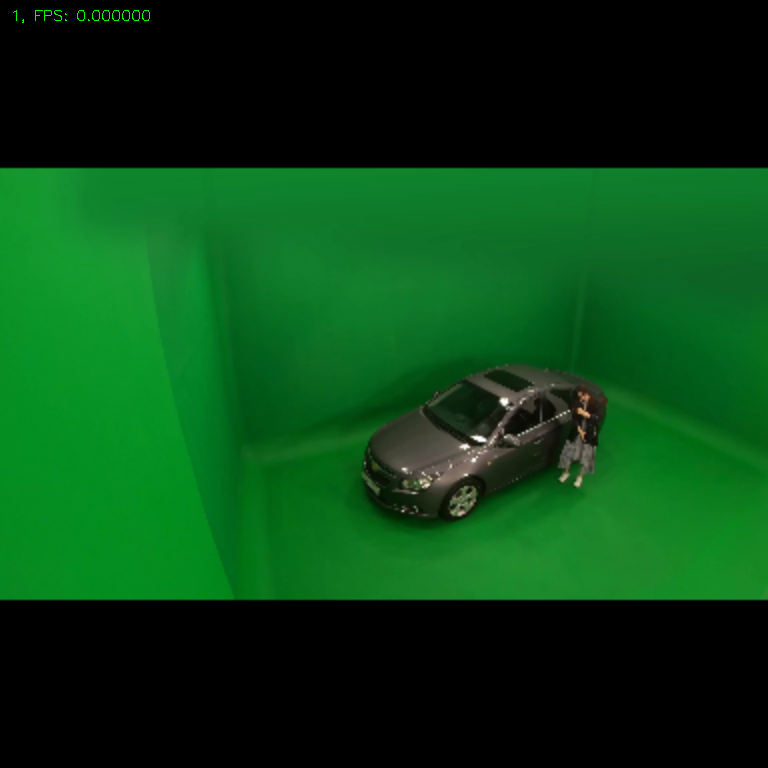

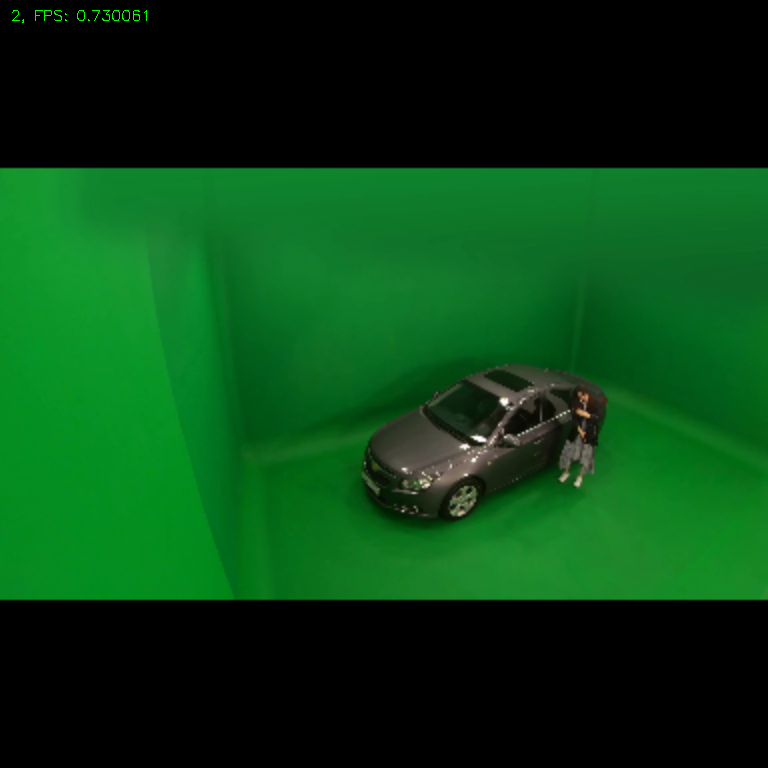

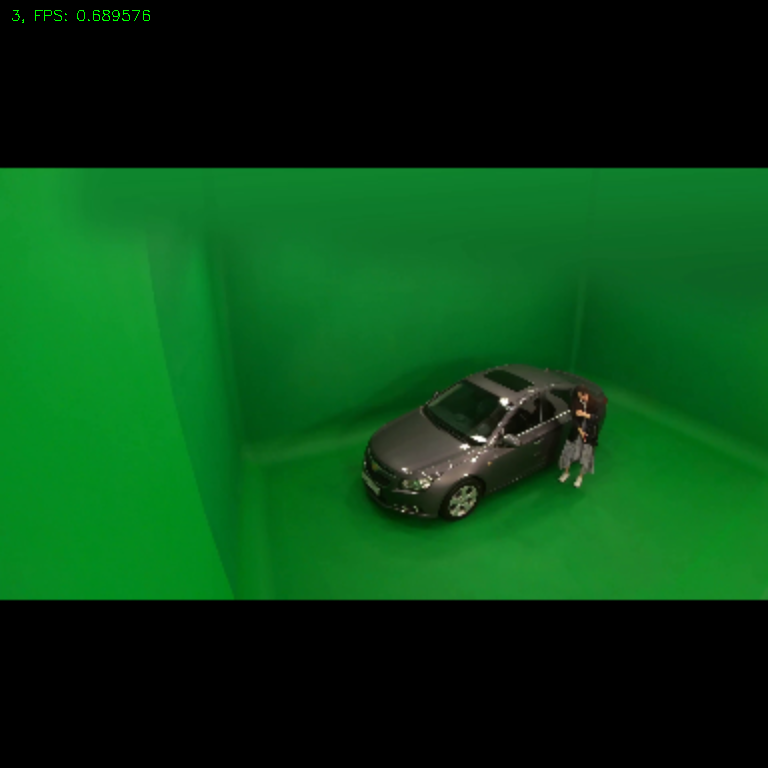

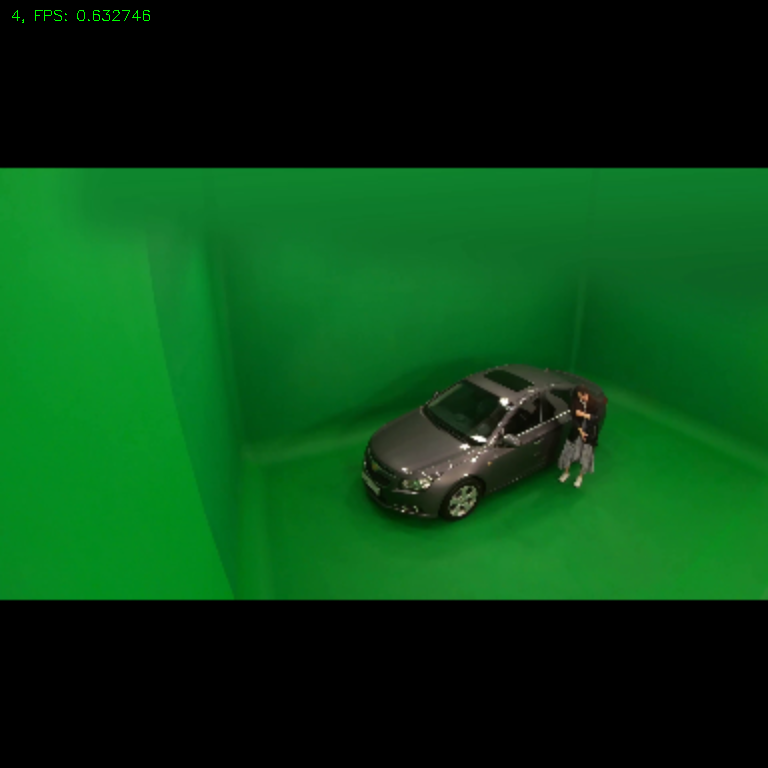

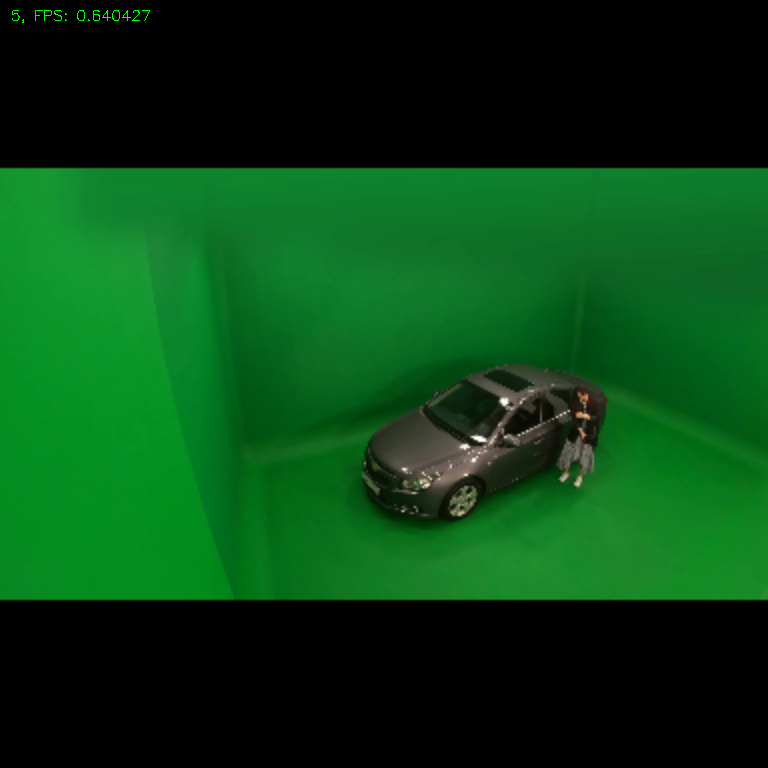

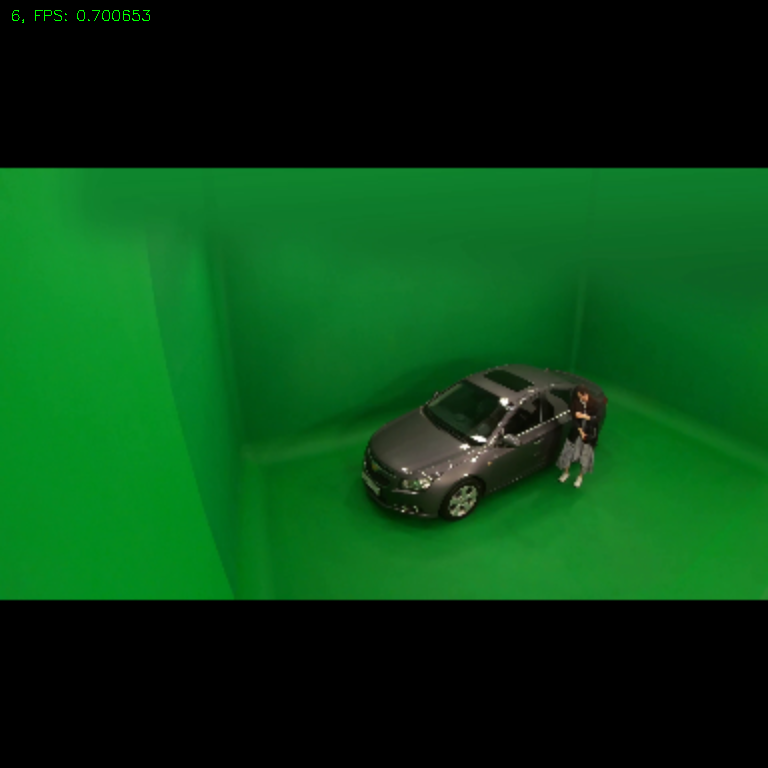

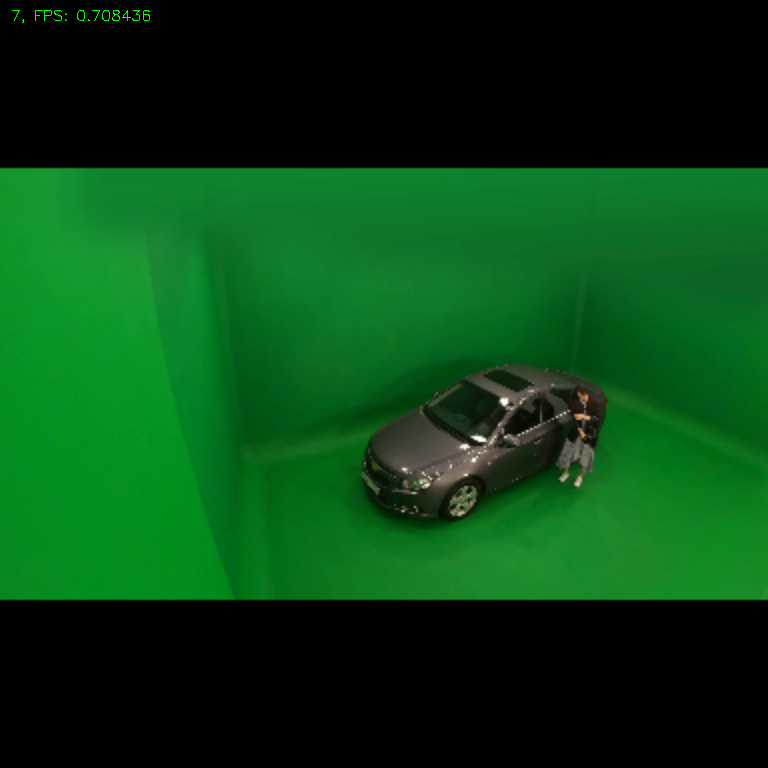

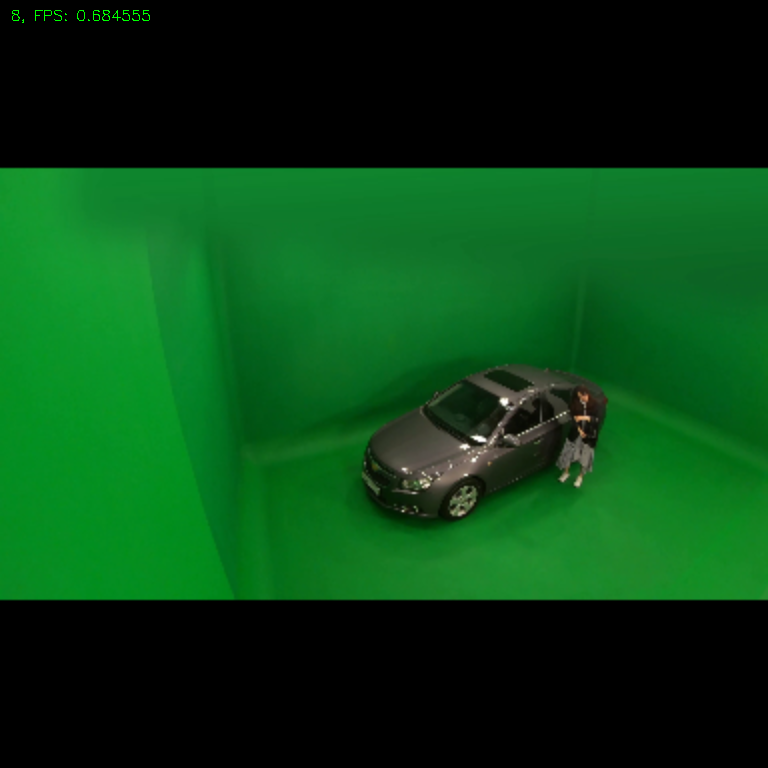

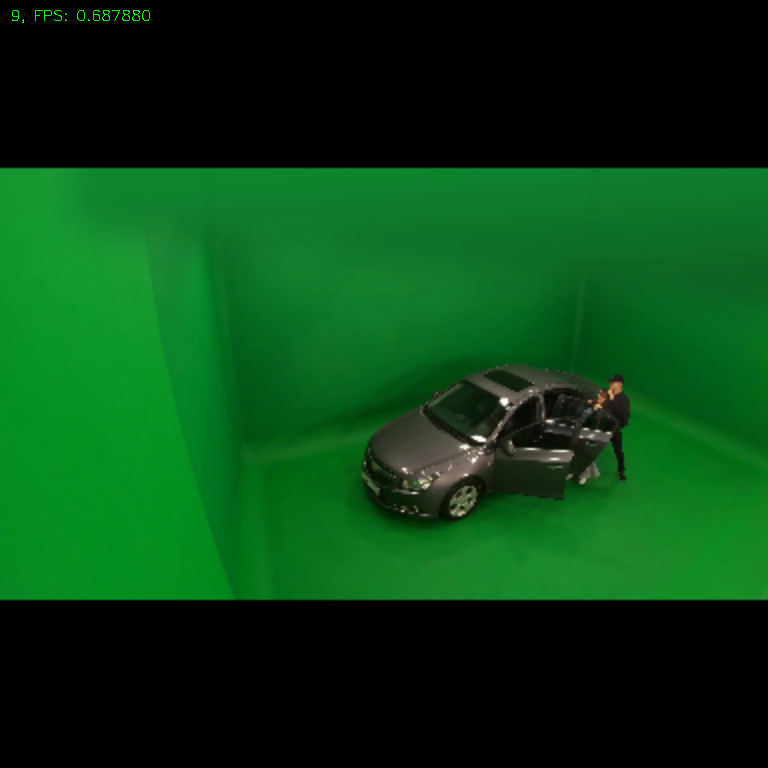

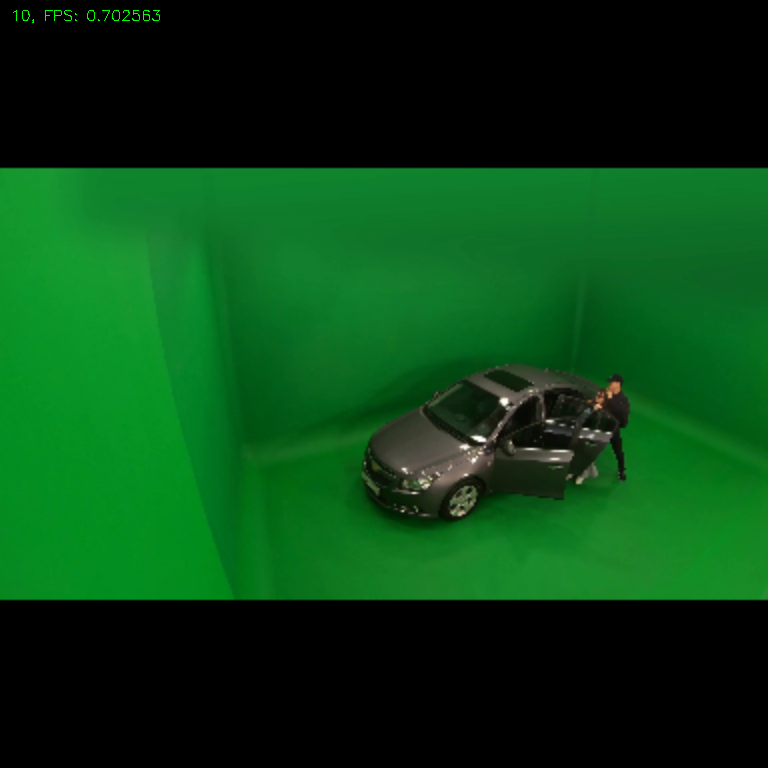

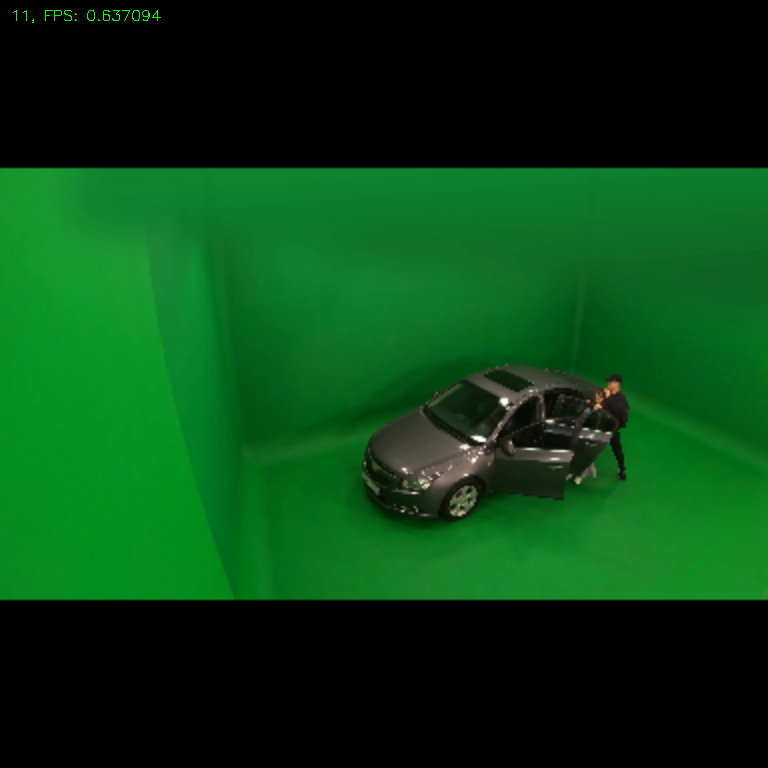

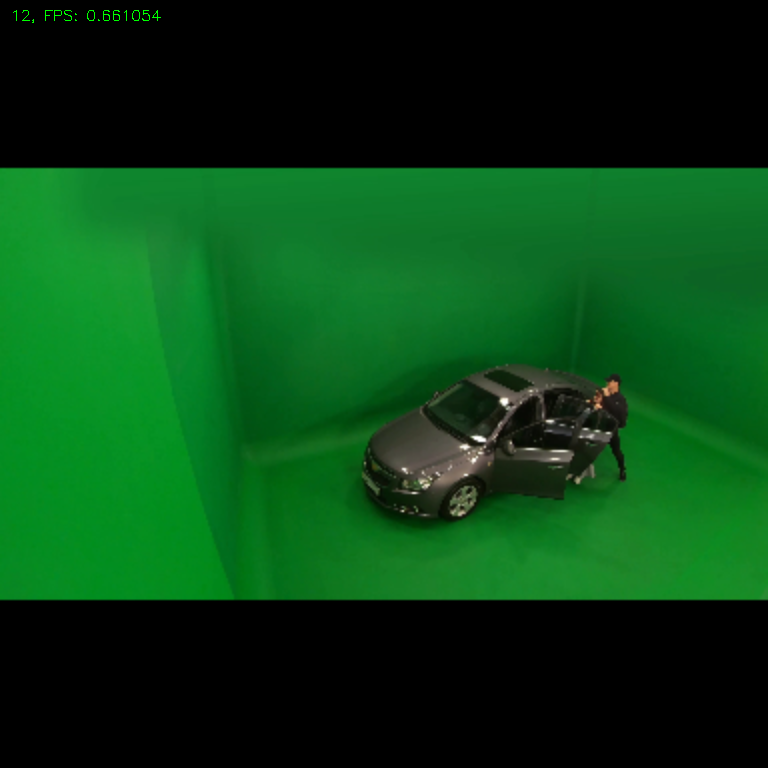

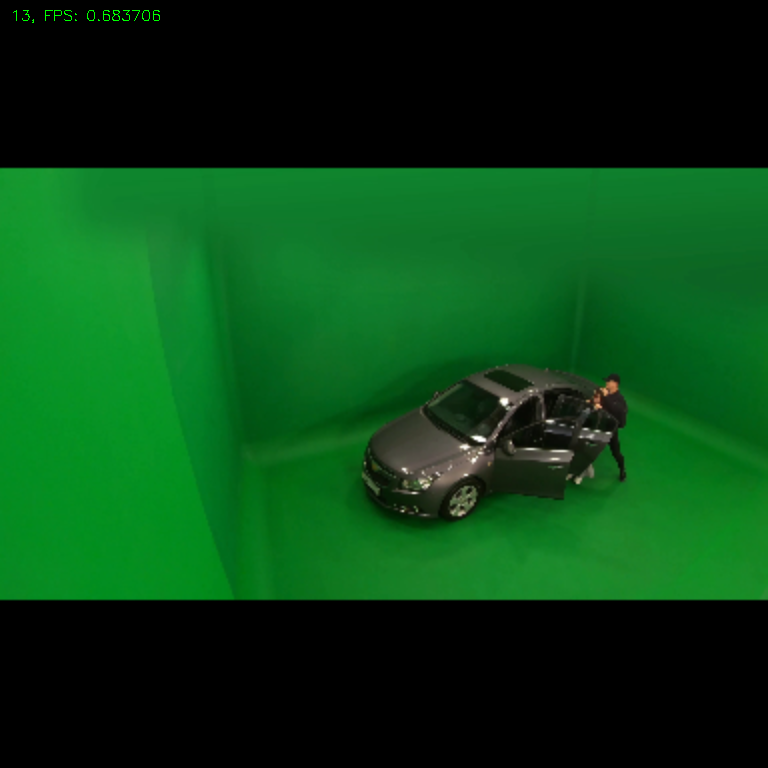

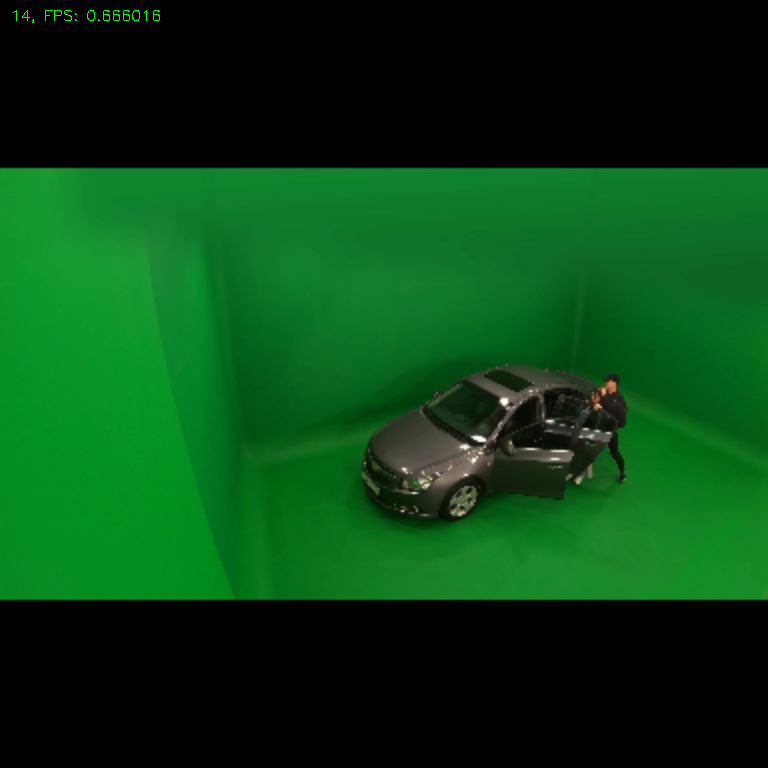

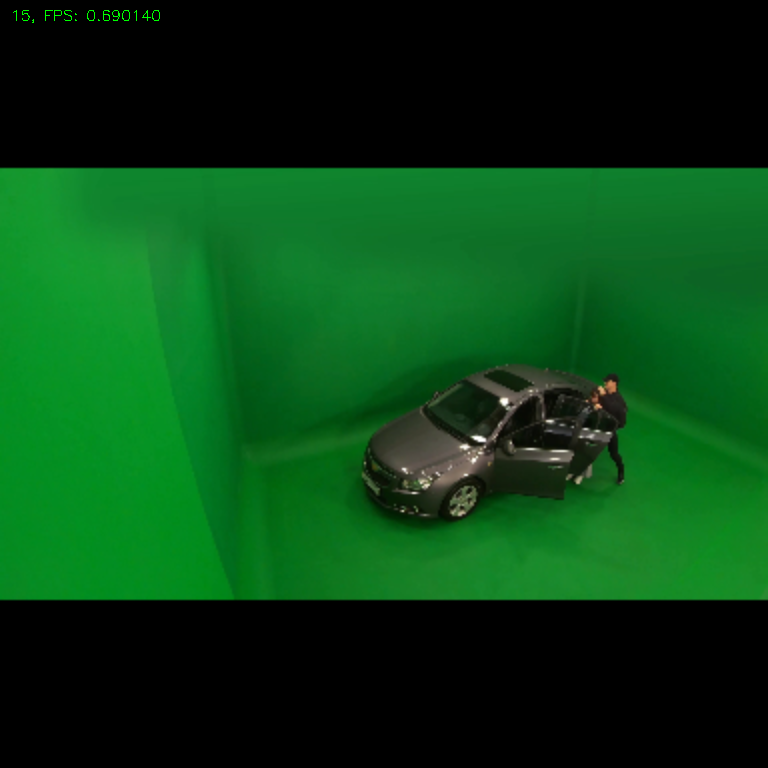

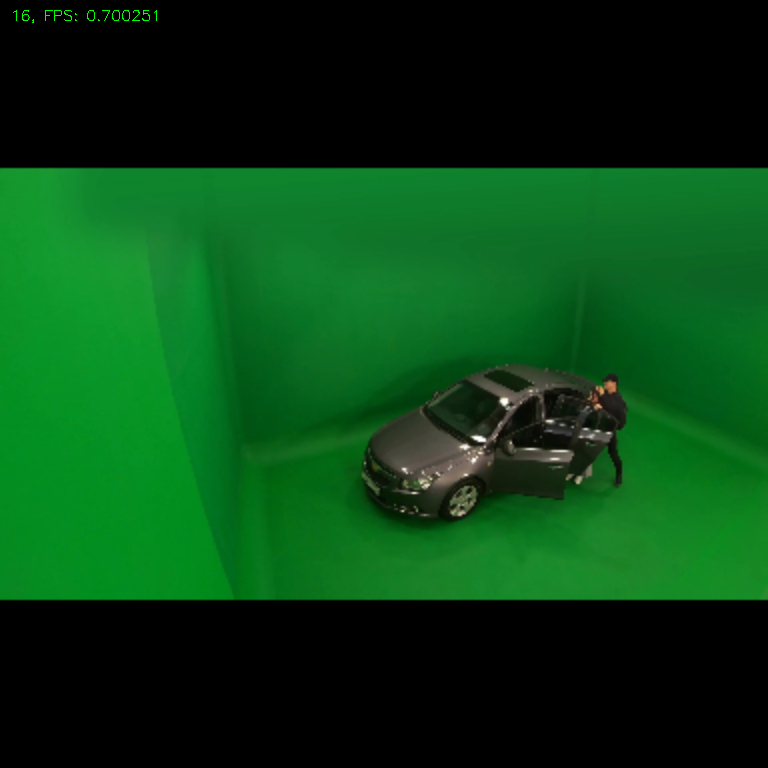

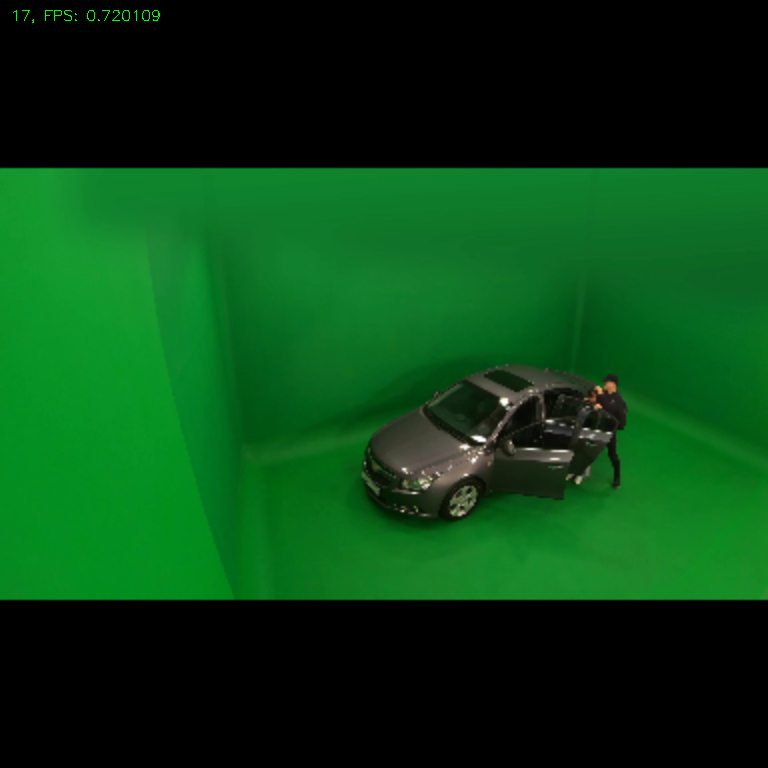

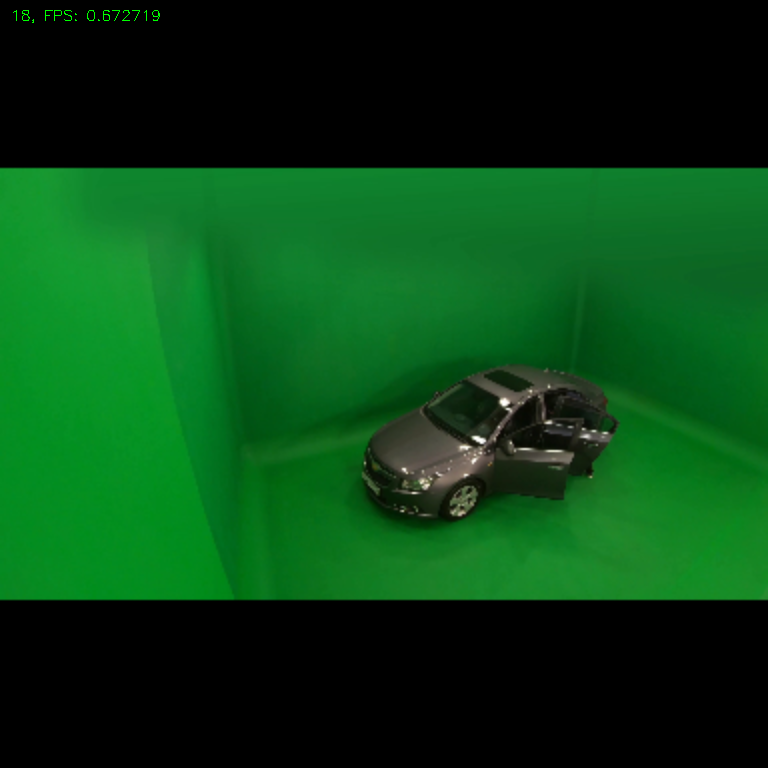

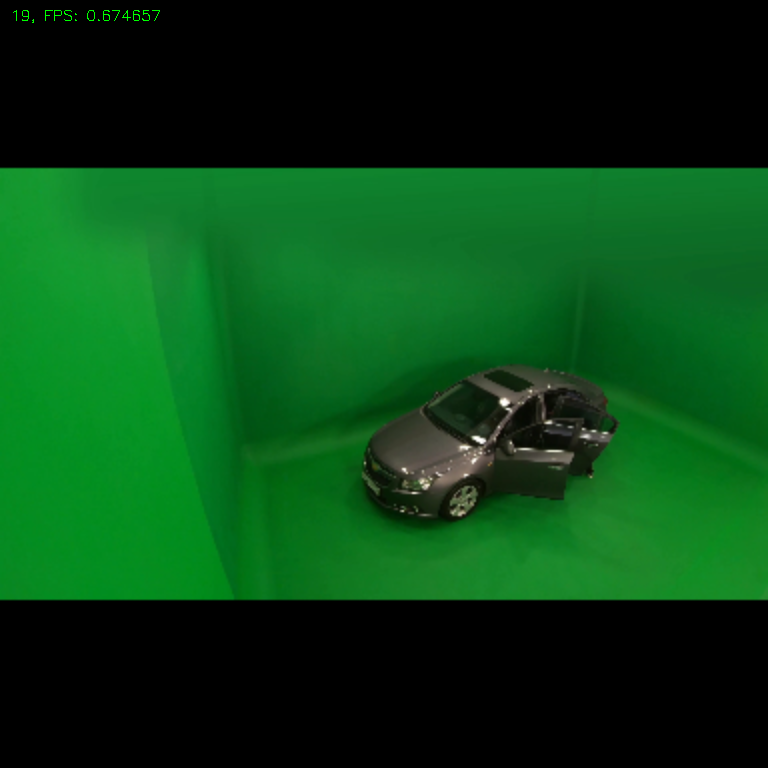

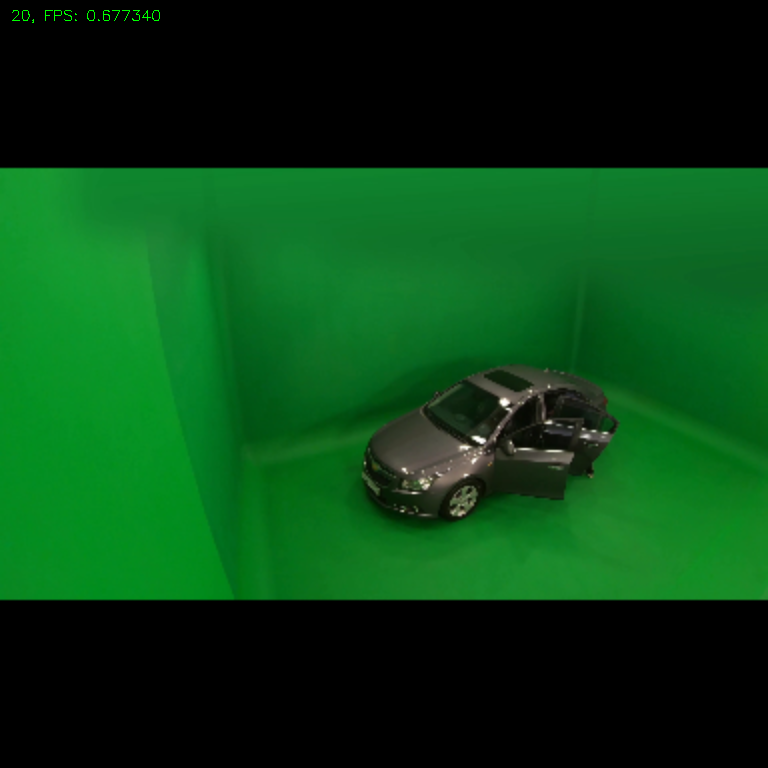

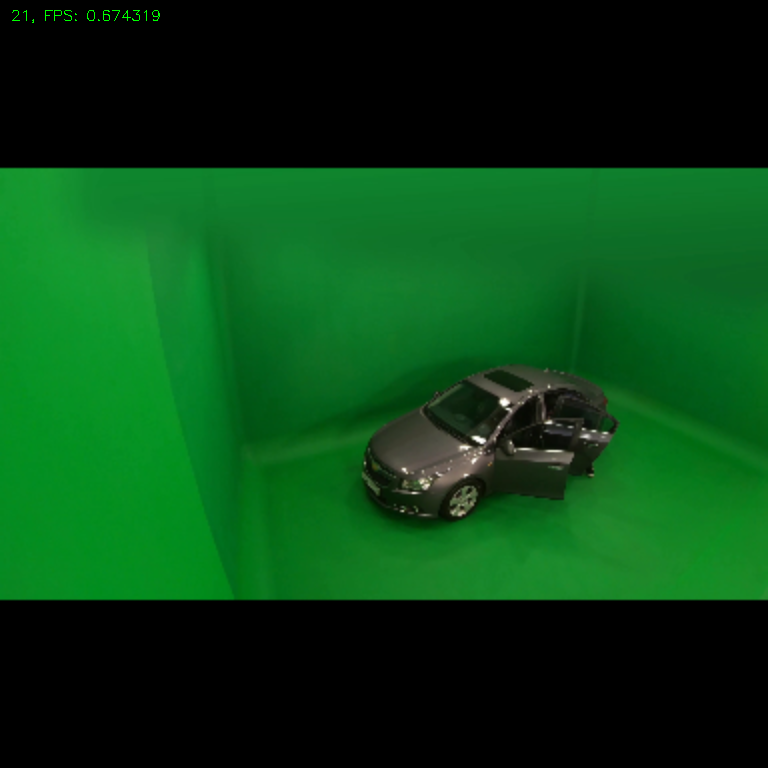

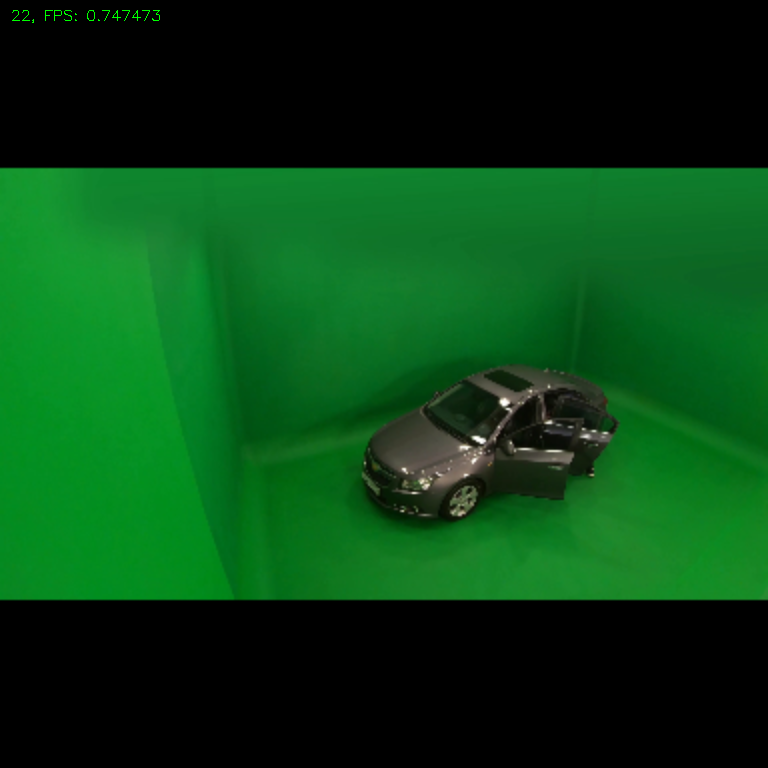

KeyboardInterrupt: 

In [40]:
while cam.grabbed():
    f += 1
    frame = cam.getitem()
    image = frame.copy()

#     # Detect humans bbox in the frame with detector model.
    detected = detect_model.detect(frame, need_resize=False, expand_bb=10)

    # Predict each tracks bbox of current frame from previous frames information with Kalman filter.
    tracker.predict()
    # Merge two source of predicted bbox together.
    for track in tracker.tracks:
        det = torch.tensor([track.to_tlbr().tolist() + [0.5, 1.0, 0.0]], dtype=torch.float32)
        detected = torch.cat([detected, det], dim=0) if detected is not None else det

    detections = []  # List of Detections object for tracking.
    if detected is not None:
        #detected = non_max_suppression(detected[None, :], 0.45, 0.2)[0]
        # Predict skeleton pose of each bboxs.
        poses = pose_model.predict(frame, detected[:, 0:4], detected[:, 4])

        # Create Detections object.
        detections = [Detection(kpt2bbox(ps['keypoints'].numpy()),
                                np.concatenate((ps['keypoints'].numpy(),
                                                ps['kp_score'].numpy()), axis=1),
                                ps['kp_score'].mean().numpy()) for ps in poses]

        # VISUALIZE.
        if args.show_detected:
            for bb in detected[:, 0:5]:
                frame = cv2.rectangle(frame, (bb[0], bb[1]), (bb[2], bb[3]), (0, 0, 255), 1)

    # Update tracks by matching each track information of current and previous frame or
    # create a new track if no matched.
    tracker.update(detections)

    # Predict Actions of each track.
    for i, track in enumerate(tracker.tracks):
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        bbox = track.to_tlbr().astype(int)
        center = track.get_center().astype(int)

        action = 'pending..'
        clr = (0, 255, 0)
        # Use 30 frames time-steps to prediction.
        if len(track.keypoints_list) == 30:
            pts = np.array(track.keypoints_list, dtype=np.float32)
            out = action_model.predict(pts, frame.shape[:2])
            action_name = action_model.class_names[out[0].argmax()]
            action = '{}: {:.2f}%'.format(action_name, out[0].max() * 100)
            if action_name == 'Fall Down':
                clr = (255, 0, 0)
            elif action_name == 'Lying Down':
                clr = (255, 200, 0)

        # VISUALIZE.
        if track.time_since_update == 0:
            if args.show_skeleton:
                frame = draw_single(frame, track.keypoints_list[-1])
            frame = cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
            frame = cv2.putText(frame, str(track_id), (center[0], center[1]), cv2.FONT_HERSHEY_COMPLEX,
                                0.4, (255, 0, 0), 2)
            frame = cv2.putText(frame, action, (bbox[0] + 5, bbox[1] + 15), cv2.FONT_HERSHEY_COMPLEX,
                                0.4, clr, 1)

    # Show Frame.
    frame = cv2.resize(frame, (0, 0), fx=2., fy=2.)
    frame = cv2.putText(frame, '%d, FPS: %f' % (f, 1.0 / (time.time() - fps_time)),
                        (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    frame = frame[:, :, ::-1]
    fps_time = time.time()

    if outvid:
        writer.write(frame)

    # cv2.imshow('frame', frame)
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clear resource.
cam.stop()
if outvid:
    writer.release()
cv2.destroyAllWindows()


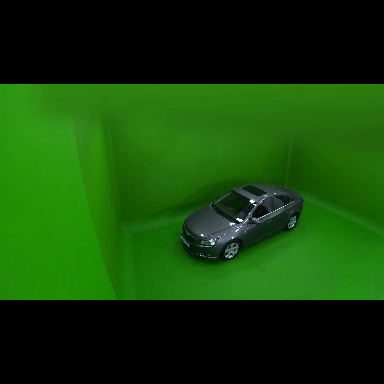

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# Example: Reading and displaying an image
cv2_imshow(image)  # Display the image


In [37]:
vcap = cv2.VideoCapture('/content/200-1_cam01_kidnap01_place01_night_spring.mp4')
vcap.get(cv2.CAP_PROP_FPS)

30.000165746772083

In [38]:
vcap

< cv2.VideoCapture 0x7b7690ec0670>

In [ ]:
import torch
torch.__version__

'2.5.1+cu121'

In [ ]:
# detected.shape #torch.Size([315, 7])


torch.Size([315, 7])

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
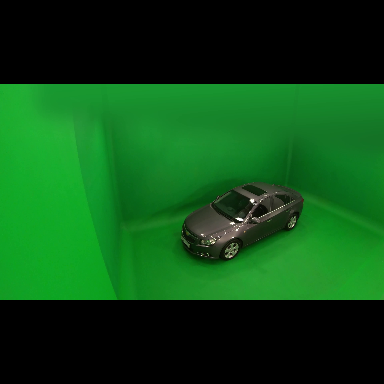

In [ ]:
image

In [4]:
!pip install "transformers==4.37.2"

In [5]:
import os
from torch.nn import functional as F
import cv2
import math
from transformers import CLIPFeatureExtractor,CLIPVisionModel
import numpy as np


model_path = 'openai/clip-vit-large-patch14-336'
feature_extractor = CLIPFeatureExtractor.from_pretrained(model_path)
vision_tower = CLIPVisionModel.from_pretrained(model_path).cuda()
vision_tower.requires_grad_(False)


def get_resized_wh(width, height, max_size):
    if width > max_size or height > max_size:
        if width > height:
            new_width = max_size
            new_height = int(height * (max_size / width))
        else:
            new_height = max_size
            new_width = int(width * (max_size / height))
    else:
        new_width = width
        new_height = height
    return new_width, new_height

def check_pure(mtx):
    unique_elements = np.unique(mtx)
    return len(unique_elements) == 1

def extract_second(image_filename):
    return image_filename.split('/')[-1].replace('.png', '').split('_')[-1]

def calculate_clip_feature_sim_2(image_1, image_2):
    input_1 = feature_extractor(images=image_1, return_tensors="pt", padding=True)
    input_2 = feature_extractor(images=image_2, return_tensors="pt", padding=True)
    image_feature_1 = vision_tower(**input_1.to(device=vision_tower.device), output_hidden_states=True).hidden_states[-1][:, 0]
    image_feature_2 = vision_tower(**input_2.to(device=vision_tower.device), output_hidden_states=True).hidden_states[-1][:, 0]
    similarity = F.cosine_similarity(image_feature_1.to(device='cpu'), image_feature_2.to(device='cpu'), dim=1)
    print(f'Sim: {similarity}')
    return similarity

def frame_interval_file(video_path, keyframe_interval, shortest_duration, longest_duration, window_threshold, output_dir):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = math.ceil(video_fps * keyframe_interval)
    frame_list = []
    cnt_tmp = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if cnt_tmp / video_fps > longest_duration:
            break
        if cnt_tmp == 0 and check_pure(frame) == True:
            pure_cnt = 1
            while pure_cnt < frame_interval:
                ret, frame = cap.read()
                if check_pure(frame) != True:
                    break
                pure_cnt += 1
        frame_list.append(frame)
        cnt_tmp += 1
    if len(frame_list) > math.ceil(video_fps * shortest_duration):
        start_frame_idx = 0
        selected_frame_list = [0]
        if len(frame_list) > frame_interval:
            for i in range(1, len(frame_list)):
                if i % frame_interval == 0:
                    dynamic_sim = calculate_clip_feature_sim_2(frame_list[start_frame_idx], frame_list[i])
                    if dynamic_sim < window_threshold:
                        selected_frame_list.append(i)
                        start_frame_idx = i
        if len(selected_frame_list) == 1:
            selected_frame_list.append(len(frame_list)-1)
        elif (len(frame_list)-selected_frame_list[-1]) >= frame_interval:
            selected_frame_list.append(len(frame_list)-1)
        for fc in selected_frame_list:
            current_time = fc / video_fps
            time_str = f"{current_time:04.2f}"
            frame_filename = f"frame_{time_str}.png"
            frame_filename = os.path.join(output_dir, frame_filename)
            os.makedirs(output_dir, exist_ok=True)
            new_width, new_height = get_resized_wh(width, height, 1024)
            if new_width == width and new_height == height:
                pass
            else:
                frame_list[fc] = cv2.resize(frame_list[fc], (new_width, new_height), interpolation=cv2.INTER_AREA)
            suc = cv2.imwrite(frame_filename, frame_list[fc])
            if not suc:
                print(f"Failed to save frame {time_str} to {frame_filename}.")
    cap.release()


# if __name__=="__main__":
#     video_path = '/content/200-1_cam01_kidnap01_place01_night_spring.mp4'
#     keyframe_interval = 2
#     shortest_duration = 10
#     longest_duration = 120
#     window_threshold = 0.93
#     output_dir = 'example/'
#     # save keyframes to 'output_dir'
    # frame_interval_file(video_path, keyframe_interval, shortest_duration, longest_duration, window_threshold, output_dir)

In [2]:
# prompt: huggingface login

!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [7]:
video_path = '/content/200-1_cam01_kidnap01_place01_night_spring.mp4'
keyframe_interval = 4
shortest_duration = 10
# longest_duration = 120
longest_duration = 10
window_threshold = 0.93
output_dir = '/content'
# save keyframes to 'output_dir'
frame_interval_file(video_path, keyframe_interval, shortest_duration, longest_duration, window_threshold, output_dir)

Sim: tensor([0.9717])
Sim: tensor([0.9633])


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
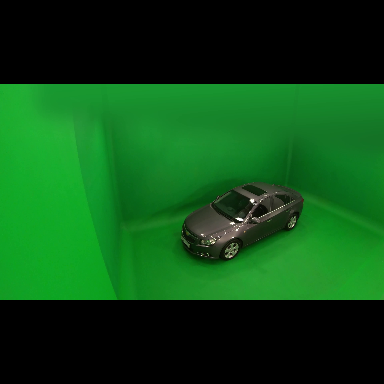

In [ ]:
frame

In [ ]:
image_size = image.shape[:2]
torch.FloatTensor([image_size])

tensor([[384., 384.]])

In [ ]:
scf = torch.min(416/ torch.FloatTensor([image_size]), 1)[0]

In [ ]:
scf

tensor([1.0833])

In [ ]:
def xywh2xyxy(x):
    y = x.new(x.shape)
    # y = torch.zeros_like(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2

def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """
    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output

In [ ]:
model = Darknet('/content/yolov3-tiny-onecls.cfg').to('cuda')
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, aff

In [ ]:
transf_fn = transforms.ToTensor()
image = transf_fn(image)[None, ...]
# detected = model(image.to('cuda'))


In [ ]:
image.shape

torch.Size([1, 3, 384, 384])

In [ ]:
detected = model(image.to('cuda'))


In [ ]:
detected.shape

torch.Size([1, 2160, 6])

In [ ]:
x = detected[..., :4]

In [ ]:
y = x.new(x.shape)


In [ ]:
y[..., 0] = x[..., 0] - x[..., 2] / 2
y[..., 1] = x[..., 1] - x[..., 3] / 2

In [ ]:
y.shape

torch.Size([1, 2160, 4])

In [ ]:
y.shape

torch.Size([1, 2160, 4])

In [ ]:
detected[..., :4] = xywh2xyxy(detected[..., :4])

TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not torch.Size

In [ ]:
output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output

In [ ]:
!pip freeze > requirments.txt


In [ ]:
detected = non_max_suppression(detected, 0.45, 0.2)[0]


TypeError: can't assign a NoneType to a torch.FloatTensor

In [ ]:
detected = model(image.to('cuda'))
        detected = non_max_suppression(detected, conf_thres, nms)[0]
        if detected is not None:
            detected[:, [0, 2]] -= (input_size - scf * image_size[1]) / 2
            detected[:, [1, 3]] -= (input_size - scf * image_size[0]) / 2
            detected[:, 0:4] /= scf

            detected[:, 0:2] = np.maximum(0, detected[:, 0:2] - 10)
            detected[:, 2:4] = np.minimum(image_size[::-1], detected[:, 2:4] + 10)

!git clone https://github.com/GajuuzZ/Human-Falling-Detect-Tracks.git

In [ ]:
detected = detect_model.detect(frame, need_resize=False, expand_bb=10)
   def __init__(self,
                 input_size=416,
                #  config_file='Models/yMAolo-tiny-onecls/yolov3-tiny-onecls.cfg',
                 config_file = '/content/yolov3-tiny-onecls.cfg',
                 weight_file='ㅁ',
                 nms=0.2,
                 conf_thres=0.45,
                 device='cuda'):
        self.input_size = input_size
        self.model = Darknet(config_file).to(device)
        # self.model.load_state_dict(torch.load(weight_file))
        self.model.eval()
        self.device = device

        self.nms = nms
        self.conf_thres = conf_thres

        self.resize_fn = ResizePadding(input_size, input_size)
        self.transf_fn = transforms.ToTensor()
def detect(self, image, need_resize=True, expand_bb=5):
        """
        Args:
            image: (numpy array) Single RGB image to detect.,
            need_resize: (bool) Resize to input_size before feed and will return bboxs
                with scale to image original size.,
            expand_bb: (int) Expand boundary of the boxs.
        Returns:
            (torch.float32) Of each detected object contain a
                [top, left, bottom, right, bbox_score, class_score, class]
            return `None` if no detected.
        """
        image_size = (self.input_size, self.input_size)
        if need_resize:
            image_size = image.shape[:2]
            image = self.resize_fn(image)

        image = self.transf_fn(image)[None, ...]
        scf = torch.min(self.input_size / torch.tensor([image_size],dtype= torch.float32), 1)[0]

        detected = self.model(image.to(self.device))
        detected = non_max_suppression(detected, self.conf_thres, self.nms)[0]
        if detected is not None:
            detected[:, [0, 2]] -= (self.input_size - scf * image_size[1]) / 2
            detected[:, [1, 3]] -= (self.input_size - scf * image_size[0]) / 2
            detected[:, 0:4] /= scf

            detected[:, 0:2] = np.maximum(0, detected[:, 0:2] - expand_bb)
            detected[:, 2:4] = np.minimum(image_size[::-1], detected[:, 2:4] + expand_bb)

        return detected